# Analyzing Political Risk Data

- COMPSS 224B: Quantitative Political Risk
- Authors: Iris Malone and Mark Rosenberg
- Last Revised: 2 May 2025

This notebook will walk you through some basic model-agnotistic tools.


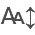

In [1]:
import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
from itables import show

# Inspecting Your Data

In [2]:
fl = pd.read_csv("FearonLaitin.csv", na_values='.')

In [3]:
fl.columns

Index(['Unnamed: 0', 'country', 'ccode', 'year', 'yrentry', 'region', 'onset',
       'wars', 'warl', 'pop', 'milper', 'milex', 'infmort', 'lifeexp',
       'natresrents', 'gini', 'gdpe', 'gdpo', 'madgdp', 'gdp', 'gdpsource',
       'gdpl', 'lgdpl', 'lpopl', 'nwstate', 'oil', 'lmtnest', 'ncontig',
       'pch1', 'ethfrac', 'ef', 'relfrac', 'polity2', 'democ', 'anoc', 'dem',
       'anocl', 'deml'],
      dtype='object')

In [4]:
fl['onset'].describe()
fl['onset'].value_counts() #very rare event

onset
0    8389
1     126
Name: count, dtype: int64

In [5]:
fl.head(5)

Unnamed: 0                   country  ccode  year  yrentry region  onset  \
0           1  United States of America      2  1945     1816   West      0   
1           2  United States of America      2  1946     1816   West      0   
2           3  United States of America      2  1947     1816   West      0   
3           4  United States of America      2  1948     1816   West      0   
4           5  United States of America      2  1949     1816   West      0   

   wars  warl          pop  ...  pch1  ethfrac        ef  relfrac  polity2  \
0     0     0  140094251.2  ...   0.0  0.35695  0.490957    0.596     10.0   
1     0     0  141556987.1  ...   0.0  0.35695  0.490957    0.596     10.0   
2     0     0  144297239.0  ...   0.0  0.35695  0.490957    0.596     10.0   
3     0     0  147382900.8  ...   0.0  0.35695  0.490957    0.596     10.0   
4     0     0  149944941.2  ...   0.0  0.35695  0.490957    0.596     10.0   

   democ  anoc  dem  anocl  deml  
0   10.0   0.0  1.0    0.0   1.0  
1   10.0   0.0  1.0    0.0   1.0  
2   10.0   0.0  1.0    0.0   1.0  
3   10.0   0.0  1.0    0.0   1.0  
4   10.0   0.0  1.0    0.0   1.0  

[5 rows x 38 columns]

Look at correlations

<Axes: >

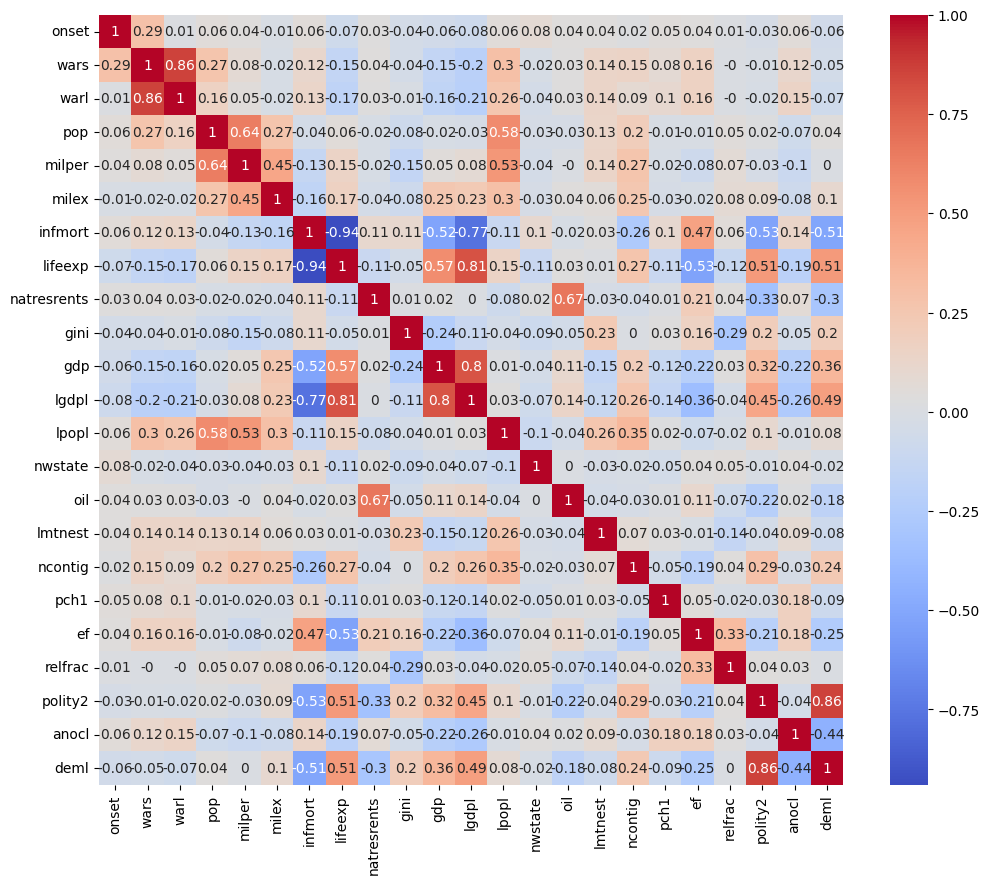

In [6]:
import matplotlib.pyplot as plt
meta_cols = ['Unnamed: 0', 'country', 'ccode', 'year', 'yrentry', 'region', 'gdpsource', 'gdpe', 'gdpo', 'madgdp', 'ethfrac', 'anoc', 'dem', 'democ', 'gdpl']

corr_matrix = fl.drop(meta_cols, axis=1, errors='ignore').select_dtypes(include='number').corr().round(2)
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)

Look at distributions

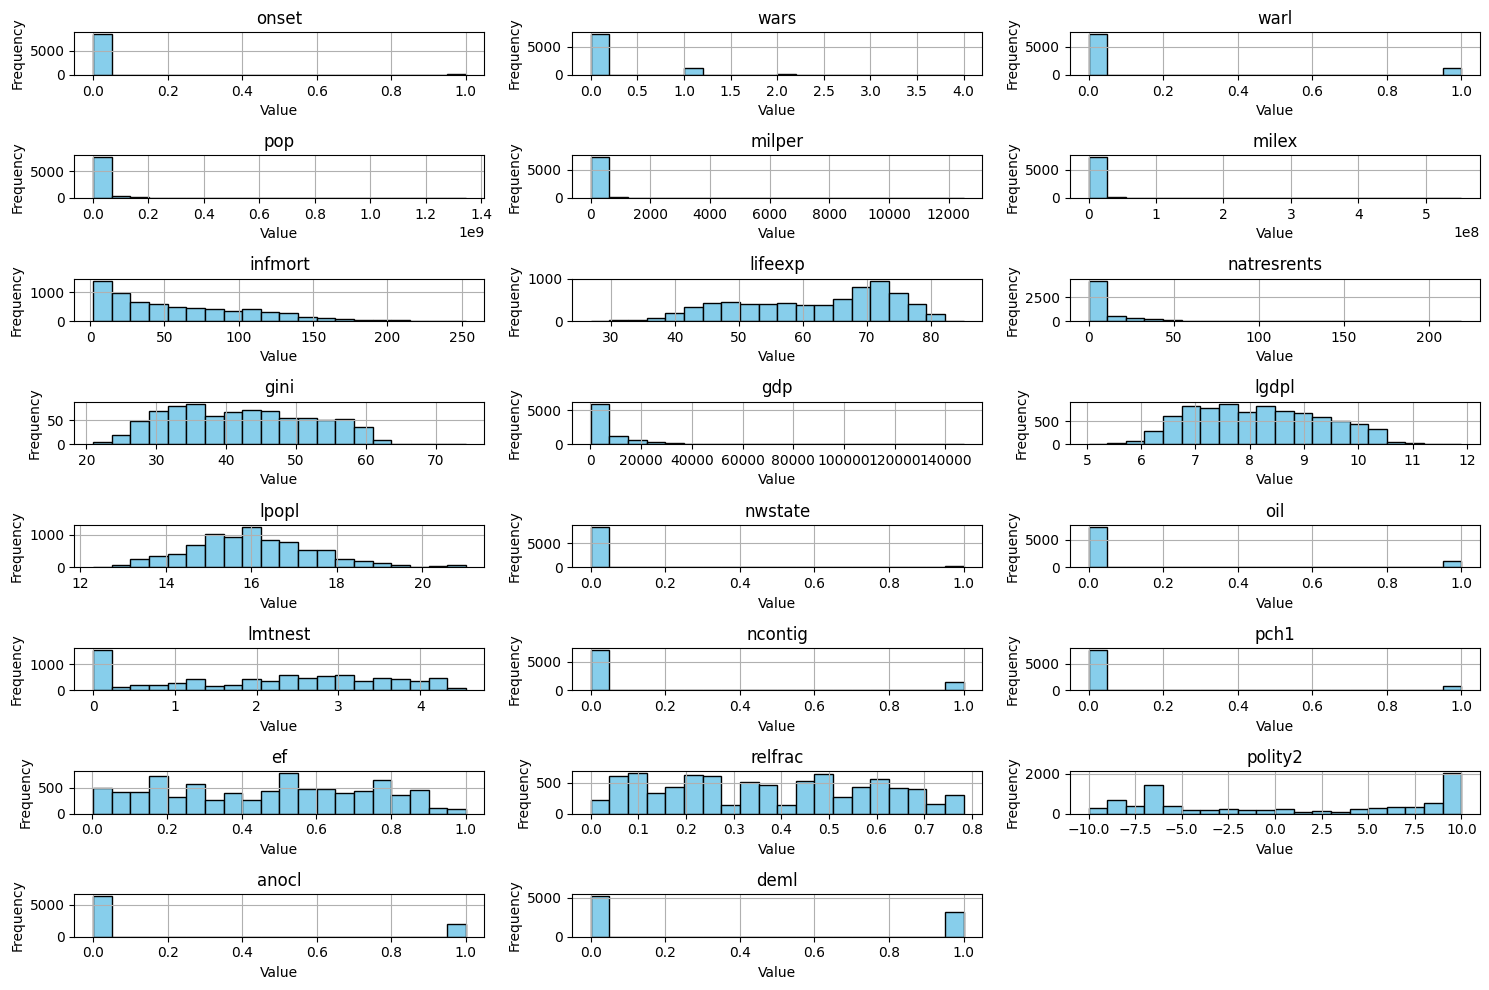

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def plot_histograms(df, bins=20, figsize=(15, 10), color='skyblue'):
    """
    Plots histograms for all numeric columns in the DataFrame.
    """
    numeric_cols = df.select_dtypes(include='number').columns
    num_cols = len(numeric_cols)

    if num_cols == 0:
        print("No numeric columns to plot.")
        return

    cols = 3  # number of plots per row
    rows = (num_cols + cols - 1) // cols

    plt.figure(figsize=figsize)
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(rows, cols, i)
        df[col].hist(bins=bins, color=color, edgecolor='black')
        plt.title(col)
        plt.xlabel('Value')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()
plot_histograms(fl.drop(meta_cols, axis=1))

Examine missingness

<Axes: >

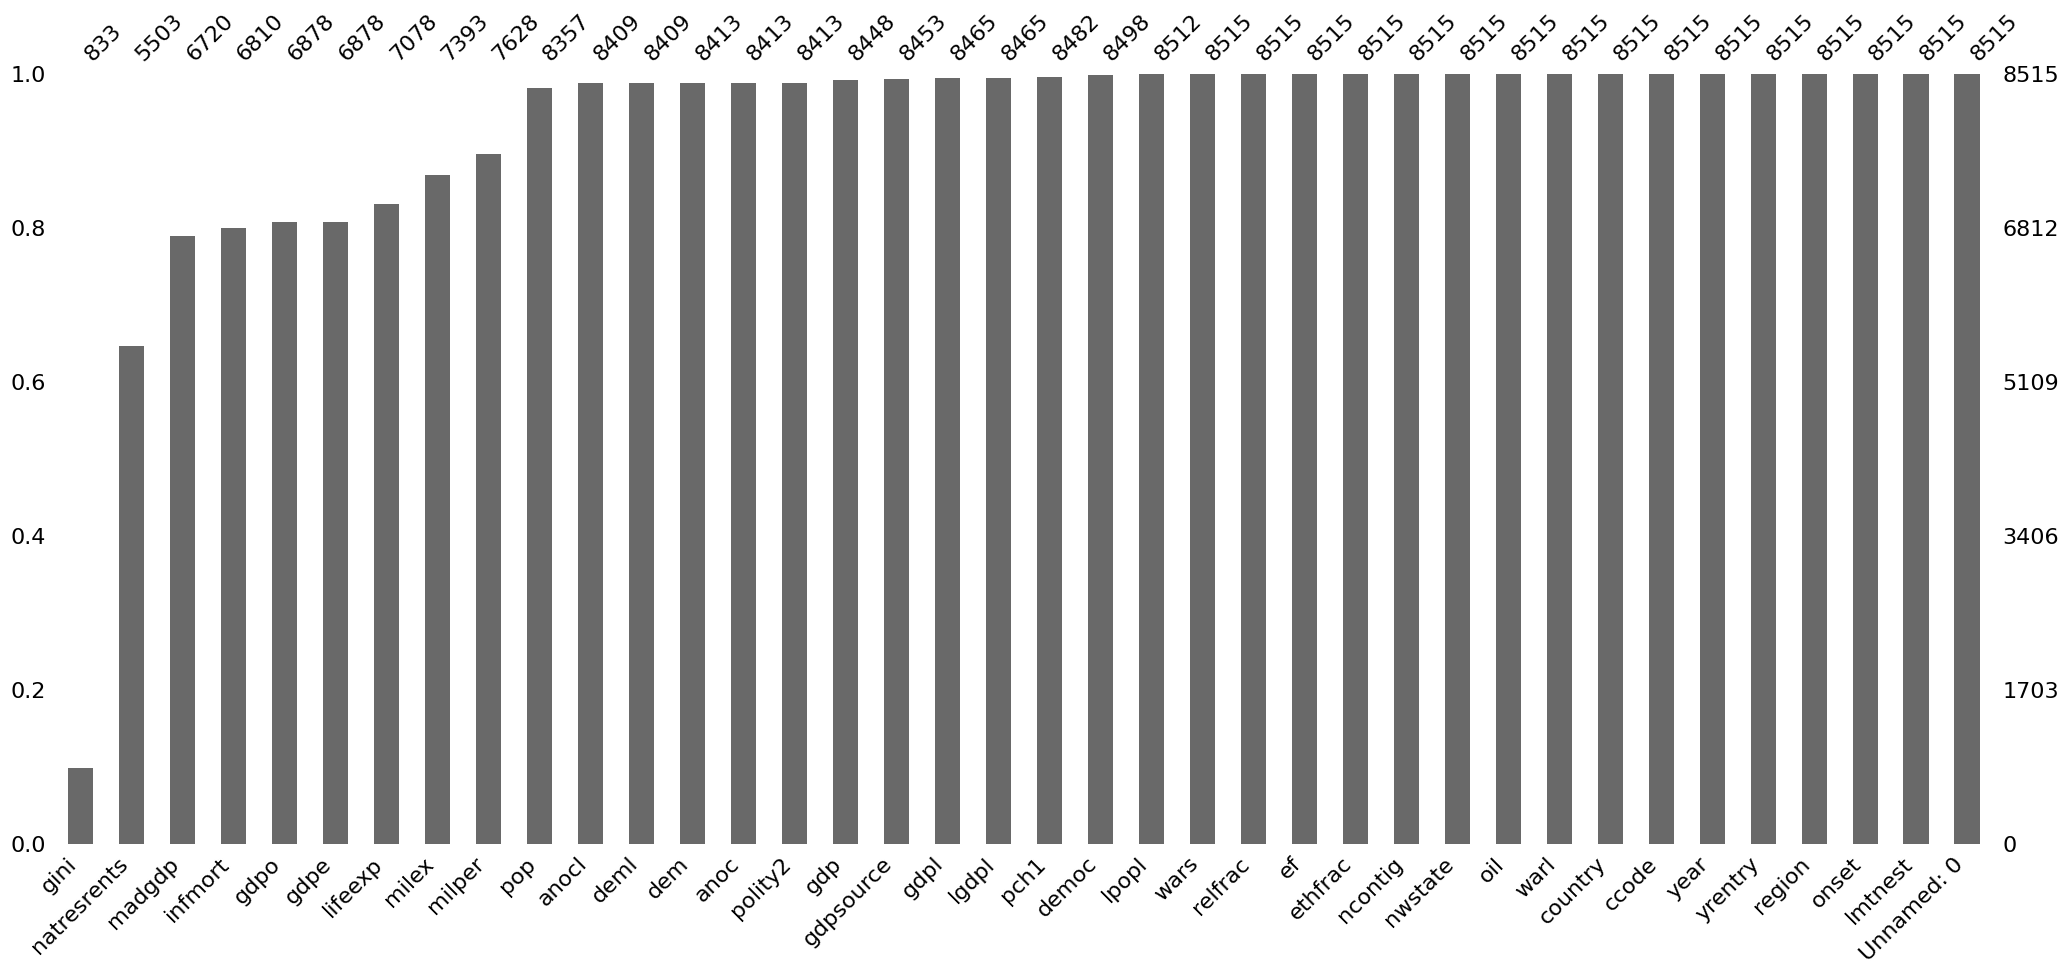

In [8]:
import missingno as msno
msno.bar(fl, sort="ascending")


*Commentary:* there's tons of missing data in their original dataset. F&L strategy appears to be to just not include covariates with high degrees of missingness (gini). In other cases they do a  lot of manual work to fill in gdp

In [9]:
# Anocracy is missing for states experiencing a civil war. This is consistent with 1 coding in polity
fl['anocl'] = fl['anocl'].transform(lambda x: x.fillna(1))
fl['polity2'] = fl['polity2'].transform(lambda x: x.fillna(0))

In [10]:
#gdp is missing for more recent years so we may interpolate
fl = fl.sort_values(['country', 'year'])
fl['lgdpl'] = fl.groupby('country')['lgdpl'].transform(
    lambda group: group.interpolate(method='linear')
)



*Commentary* Since Fearon and Laitin explain the manual research they do to fill in the others (see gdp source column , which describes their imputation and research methodology), teh rest of the data is MCAR and can be dropped.

In [11]:
#the rest of the data is mcar because we know F&L try to impute
fl_clean = fl[['onset', 'warl', 'lgdpl', 'lpopl', 'lmtnest', 'ncontig', 'oil',
              'nwstate', 'anocl', 'polity2', 'ef', 'relfrac']]
fl_clean

onset  warl     lgdpl      lpopl   lmtnest  ncontig  oil  nwstate  \
6834      0     0  6.726732  15.838828  4.198705        0    0        0   
6835      0     0  6.726732  15.838828  4.198705        0    0        0   
6836      0     0  6.755190  15.850594  4.198705        0    0        0   
6837      0     0  6.781943  15.862224  4.198705        0    0        0   
6838      0     0  6.806989  15.873948  4.198705        0    0        0   
...     ...   ...       ...        ...       ...      ...  ...      ...   
5361      0     0  8.204884  16.339738  1.360977        0    0        0   
5362      0     0  7.963576  16.337355  1.360977        0    0        0   
5363      0     0  8.281930  16.339156  1.360977        0    0        0   
5364      0     0  8.313221  16.346939  1.360977        0    0        0   
5365      0     0  8.377422  16.361385  1.360977        0    0        0   

      anocl  polity2        ef  relfrac  
6834    0.0    -10.0  0.750797   0.2718  
6835    0.0    -10.0  0.750797   0.2718  
6836    0.0    -10.0  0.750797   0.2718  
6837    0.0    -10.0  0.750797   0.2718  
6838    0.0    -10.0  0.750797   0.2718  
...     ...      ...       ...      ...  
5361    1.0     -4.0  0.366200   0.5098  
5362    1.0      1.0  0.366200   0.5098  
5363    1.0      1.0  0.366200   0.5098  
5364    1.0      1.0  0.366200   0.5098  
5365    1.0      1.0  0.366200   0.5098  

[8515 rows x 12 columns]

In [12]:
fl_clean['onset'].value_counts()

onset
0    8389
1     126
Name: count, dtype: int64


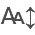

In [13]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
from itables import show

fl_clean = fl_clean.dropna()

# Base Model

We will first replicate their base model. They have no train/test split and do not correct for class imbalance (including even just using rare event logit).

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report


def evaluate_model(name, model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob > 0.5).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    spec = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred)
    nir = max(np.mean(y_test == 0), np.mean(y_test == 1))

    print(f"\n{name} Evaluation:")
    print(f"Accuracy:    {acc:.3f}")
    print(f"Precision:   {prec:.3f}")
    print(f"Recall:      {rec:.3f}")
    print(f"Specificity: {spec:.3f}")
    print(f"F1 Score:    {f1:.3f}")
    print(f"No Information Rate: {nir:.3f}")

Use stats models to get regression summary consistent with their findings

In [15]:
import statsmodels.api as sm

# Define X and y
X = fl_clean[['warl', 'lgdpl', 'lpopl', 'lmtnest', 'ncontig', 'oil',
              'nwstate', 'anocl', 'polity2', 'ef', 'relfrac']]
X = sm.add_constant(X)  # add intercept
y = fl_clean['onset']

# Fit the logistic regression model
model_stats = sm.Logit(y, X).fit()
print(model_stats.summary())

Optimization terminated successfully.
         Current function value: 0.067245
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  onset   No. Observations:                 8489
Model:                          Logit   Df Residuals:                     8477
Method:                           MLE   Df Model:                           11
Date:                Thu, 08 May 2025   Pseudo R-squ.:                  0.1236
Time:                        15:49:31   Log-Likelihood:                -570.85
converged:                       True   LL-Null:                       -651.35
Covariance Type:            nonrobust   LLR p-value:                 8.302e-29
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7080      1.486     -4.515      0.000      -9.620      -3.796
warl          -0.6648      0.

Alternatively, use sklearn to run and assess predictive performance

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2025
)




Re-run model using train/test split and stats

In [17]:
model_train = sm.Logit(y_train, X_train).fit()
print(model_train.summary())

Optimization terminated successfully.
         Current function value: 0.063442
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  onset   No. Observations:                 6791
Model:                          Logit   Df Residuals:                     6779
Method:                           MLE   Df Model:                           11
Date:                Thu, 08 May 2025   Pseudo R-squ.:                  0.1232
Time:                        15:49:31   Log-Likelihood:                -430.84
converged:                       True   LL-Null:                       -491.40
Covariance Type:            nonrobust   LLR p-value:                 1.075e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.9854      1.696     -4.118      0.000     -10.310      -3.660
warl          -0.8195      0.

Re-run model using train/test split and sklearn

In [18]:

fl_origmodel = LogisticRegression(max_iter=1000)
fl_origmodel.fit(X_train, y_train)
# Predict and evaluate on test set
y_pred = fl_origmodel.predict(X_test)

evaluate_model("Logit", fl_origmodel, X_test, y_test)



Logit Evaluation:
Accuracy:    0.981
Precision:   0.000
Recall:      0.000
Specificity: 1.000
F1 Score:    0.000
No Information Rate: 0.981


/Users/ubermenschev/Library/Python/3.13/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


*Commentary*: Note their statistically significant model has almost no predictive power.

# By Design Interpretability

## 1. Coefficient Plot

Logit models are transparent by design. For example, we can look at coefficient plot

/var/folders/0m/d48fpfjn78d7h8p68fydssdm0000gn/T/ipykernel_3970/4257547411.py:24: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='coef', y='label', data=plot_df, join=False, color='black')


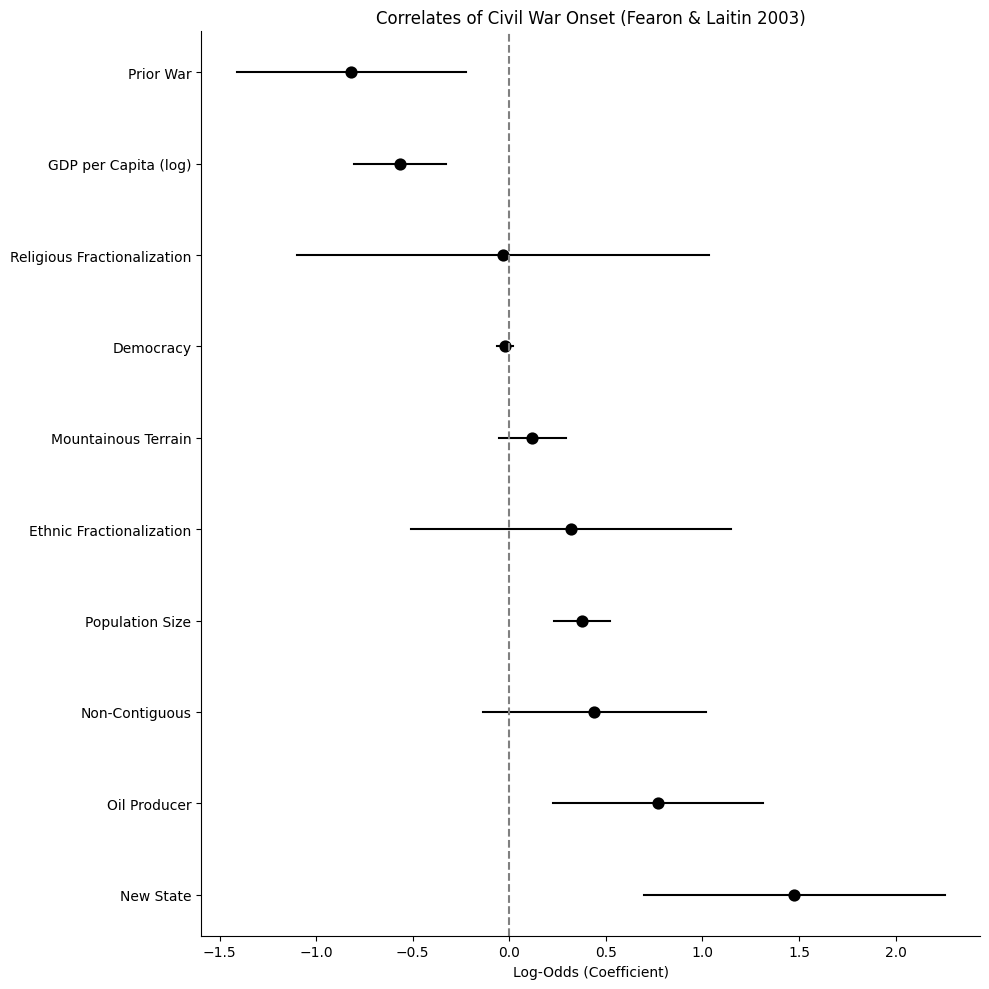

In [19]:
summary = model_train.summary2().tables[1].copy()
summary['Variable'] = summary.index
summary = summary.rename(columns={'Coef.': 'coef', '[0.025': 'lower', '0.975]': 'upper'})

# Drop intercept and sort
plot_df = summary.loc[summary.index != 'Intercept'].copy()
plot_df['label'] = plot_df['Variable'].map({
    'polity2': 'Democracy',
    'lgdpl': 'GDP per Capita (log)',
    'lpopl': 'Population Size',
    'oil': 'Oil Producer',
    'lmtnest': 'Mountainous Terrain',
    'ef': 'Ethnic Fractionalization',
     'warl': 'Prior War',
    'ncontig': 'Non-Contiguous',
    'relfrac': 'Religious Fractionalization',
    'nwstate': 'New State'
   
})
plot_df = plot_df.sort_values('coef')

# Plot
plt.figure(figsize=(10, 10))
sns.pointplot(x='coef', y='label', data=plot_df, join=False, color='black')
for _, row in plot_df.iterrows():
    plt.plot([row['lower'], row['upper']], [row['label']] * 2, color='black', linewidth=1.5)
plt.axvline(0, color='grey', linestyle='--')
plt.title('Correlates of Civil War Onset (Fearon & Laitin 2003)')
plt.xlabel('Log-Odds (Coefficient)')
plt.ylabel('')
sns.despine()
plt.tight_layout()
plt.show()


## 2. Plotting interactions and marginal effects

In [20]:
import statsmodels.formula.api as smf
model_int = smf.logit('onset ~ lgdpl + lpopl + anocl * lgdpl + oil + lmtnest + ef + warl + relfrac + ncontig + anocl + nwstate', data=fl_clean).fit()

print(model_int.summary())

Optimization terminated successfully.
         Current function value: 0.066923
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  onset   No. Observations:                 8489
Model:                          Logit   Df Residuals:                     8477
Method:                           MLE   Df Model:                           11
Date:                Thu, 08 May 2025   Pseudo R-squ.:                  0.1278
Time:                        15:49:31   Log-Likelihood:                -568.11
converged:                       True   LL-Null:                       -651.35
Covariance Type:            nonrobust   LLR p-value:                 6.241e-30
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.9920      1.563     -3.194      0.001      -8.055      -1.929
lgdpl          -0.7865   

/var/folders/0m/d48fpfjn78d7h8p68fydssdm0000gn/T/ipykernel_3970/1303073638.py:25: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='coef', y='label', data=plot_df, join=False, color='black')


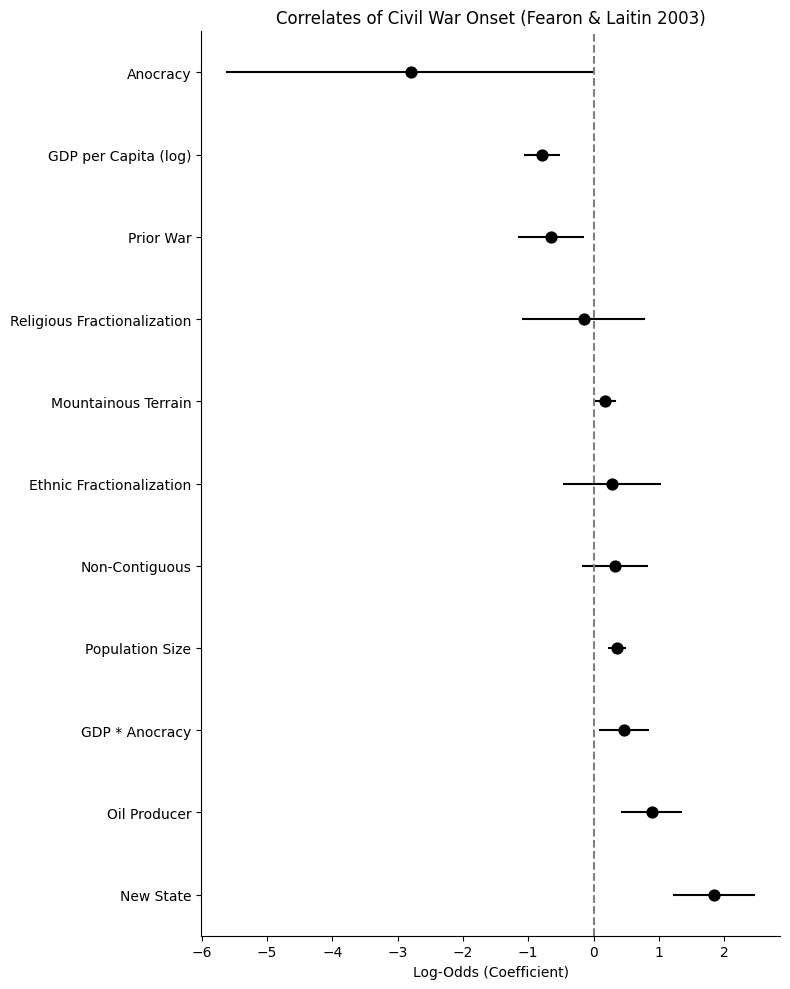

In [21]:
summary = model_int.summary2().tables[1].copy()
summary['Variable'] = summary.index
summary = summary.rename(columns={'Coef.': 'coef', '[0.025': 'lower', '0.975]': 'upper'})

# Drop intercept and sort
plot_df = summary.loc[summary.index != 'Intercept'].copy()
plot_df['label'] = plot_df['Variable'].map({
    'polity2': 'Democracy',
    'lgdpl': 'GDP per Capita (log)',
    'lpopl': 'Population Size',
    'oil': 'Oil Producer',
    'lmtnest': 'Mountainous Terrain',
    'anocl': 'Anocracy',
    'warl': 'Prior War',
    'ncontig': 'Non-Contiguous',
    'ef': 'Ethnic Fractionalization',
    'relfrac': 'Religious Fractionalization',
    'nwstate': 'New State',
    'anocl:lgdpl': 'GDP * Anocracy'
})
plot_df = plot_df.sort_values('coef')

# Plot
plt.figure(figsize=(8, 10))
sns.pointplot(x='coef', y='label', data=plot_df, join=False, color='black')
for _, row in plot_df.iterrows():
    plt.plot([row['lower'], row['upper']], [row['label']] * 2, color='black', linewidth=1.5)
plt.axvline(0, color='grey', linestyle='--')
plt.title('Correlates of Civil War Onset (Fearon & Laitin 2003)')
plt.xlabel('Log-Odds (Coefficient)')
plt.ylabel('')
sns.despine()
plt.tight_layout()
plt.show()

We can look at the marginal effect across a hypothesized set of values 

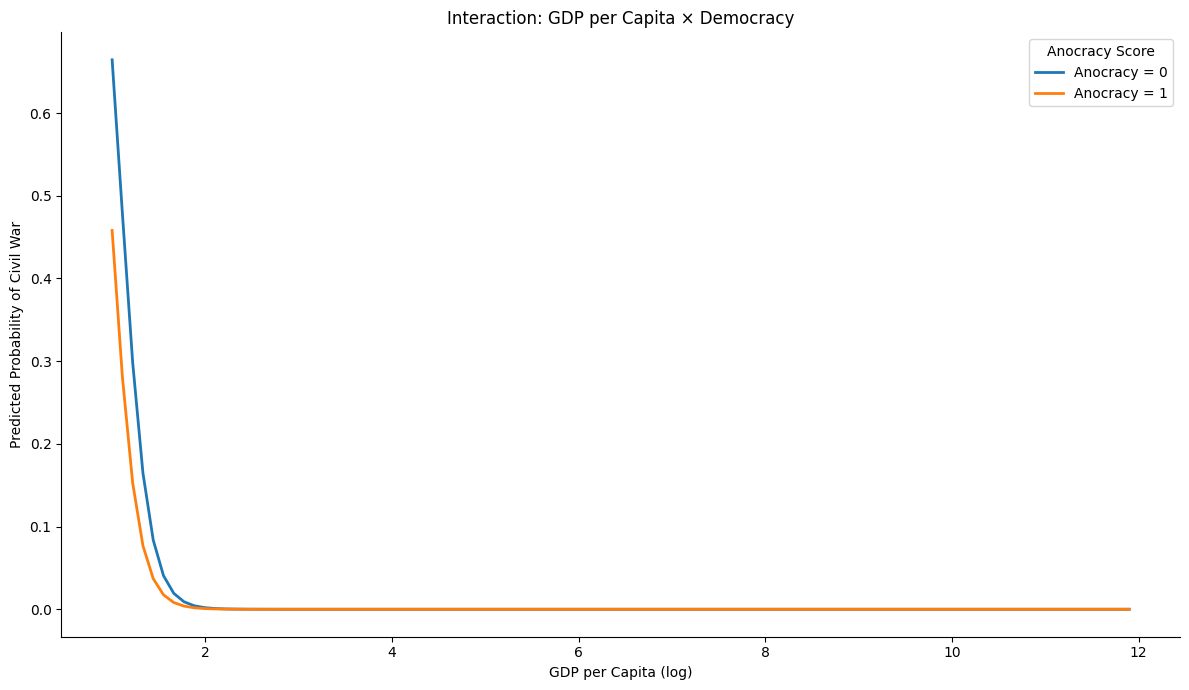

In [22]:
import numpy as np
# Create predicted values for GDP across different levels of democracy
gdp_range = np.linspace(1, fl['lgdpl'].max(), 100)
polity_levels = [0, 1]

pred_df = pd.DataFrame({
    #use our predicted range and examine at each polity level
    'lgdpl': np.tile(gdp_range, len(polity_levels)),
     # Hold other vars at mean (we can change this for simulations later on)
    'anocl': np.repeat(polity_levels, len(gdp_range)),
   'polity2': fl['polity2'].mean(), 
    'lpopl': fl['lpopl'].mean(),     
    'oil': fl['oil'].mean(),
    'lmtnest': fl['lmtnest'].mean(),
    'ef': fl['ef'].mean(),
    'relfrac': fl['relfrac'].mean(),
    'nwstate': fl['nwstate'].mean(),
       'warl': fl['warl'].mean(),
    'ncontig': fl['ncontig'].mean(),
})

pred_df['interaction'] = pred_df['lgdpl'] * pred_df['anocl']
pred_df['predicted'] = model_train.predict(pred_df)

# Plot interaction
plt.figure(figsize=(12, 7))
for pol in polity_levels:
    subset = pred_df[pred_df['anocl'] == pol]
    plt.plot(subset['lgdpl'], subset['predicted'], label=f'Anocracy = {pol}', linewidth=2)

plt.title('Interaction: GDP per Capita × Democracy')
plt.xlabel('GDP per Capita (log)')
plt.ylabel('Predicted Probability of Civil War')
plt.legend(title='Anocracy Score')
sns.despine()
plt.tight_layout()
plt.show()


# Model-Agnostic Interpretability

## 1. ROC/AUC

[0.09236974 0.008206   0.00208258 ... 0.01512241 0.00908935 0.00309901]
0.7609825180072028


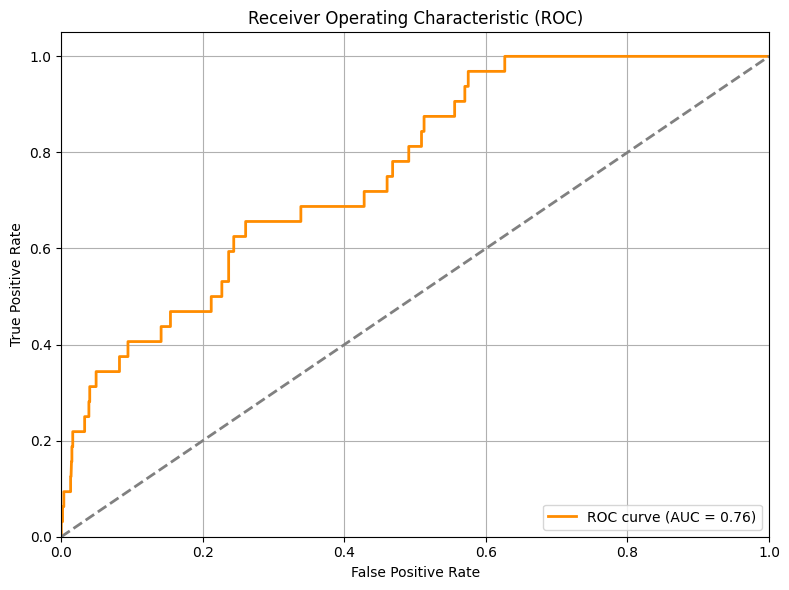

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Get predicted probabilities
y_score = fl_origmodel.predict_proba(X_test)[:, 1]  # Probability of class 1
print(y_score)
# Step 2: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)
print(roc_auc)
# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. Separation Plot

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def separation_plot(y_true, y_prob, title="Separation Plot"):
    # Combine and sort by predicted probabilities
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values(by='y_prob').reset_index(drop=True)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 5))
    for i, actual in enumerate(df['y_true']):
        color = 'black' if actual == 1 else 'lightyellow'
        ax.axvline(i, color=color, linewidth=1)

    # Overlay predicted probabilities
    ax.plot(df['y_prob'].values, color='red', linewidth=2, label='Predicted Probabilities')

    # Formatting
    ax.set_xlim(0, len(df))
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.5, 1])
    ax.set_xticks([])
    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


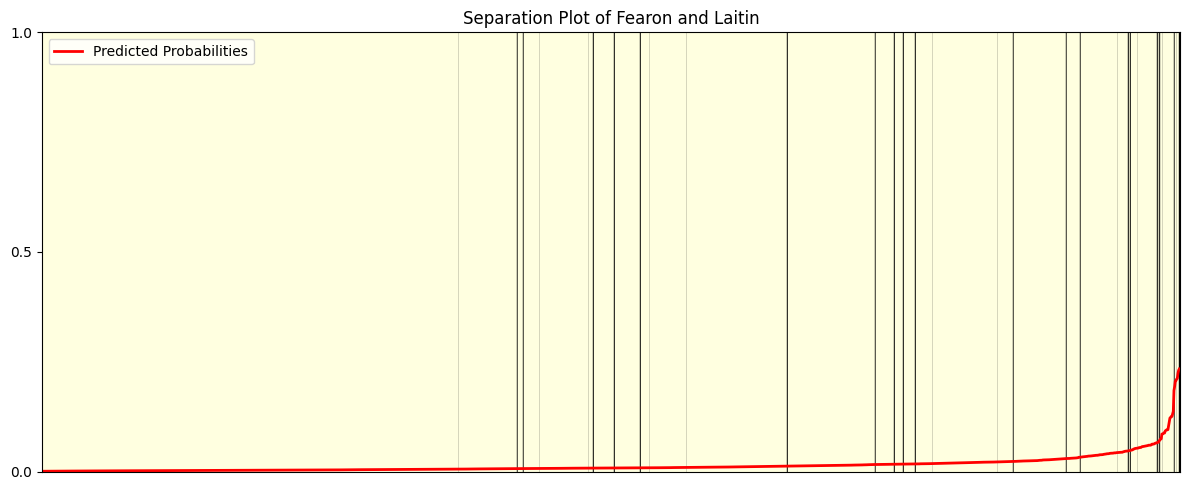

In [25]:
y_score = fl_origmodel.predict_proba(X_test)[:, 1]
separation_plot(y_test, y_score, title="Separation Plot of Fearon and Laitin")

## 3. Variable Importance Plot

    Feature  Importance_mean  Importance_std
7   nwstate         0.000155        0.000055
3     lpopl         0.000153        0.000069
9   polity2         0.000146        0.000105
2     lgdpl         0.000145        0.000056
6       oil         0.000131        0.000081
4   lmtnest         0.000126        0.000103
5   ncontig         0.000124        0.000054
10       ef         0.000121        0.000057
8     anocl         0.000109        0.000065
11  relfrac         0.000030        0.000059
1      warl         0.000021        0.000052
0     const         0.000000        0.000000


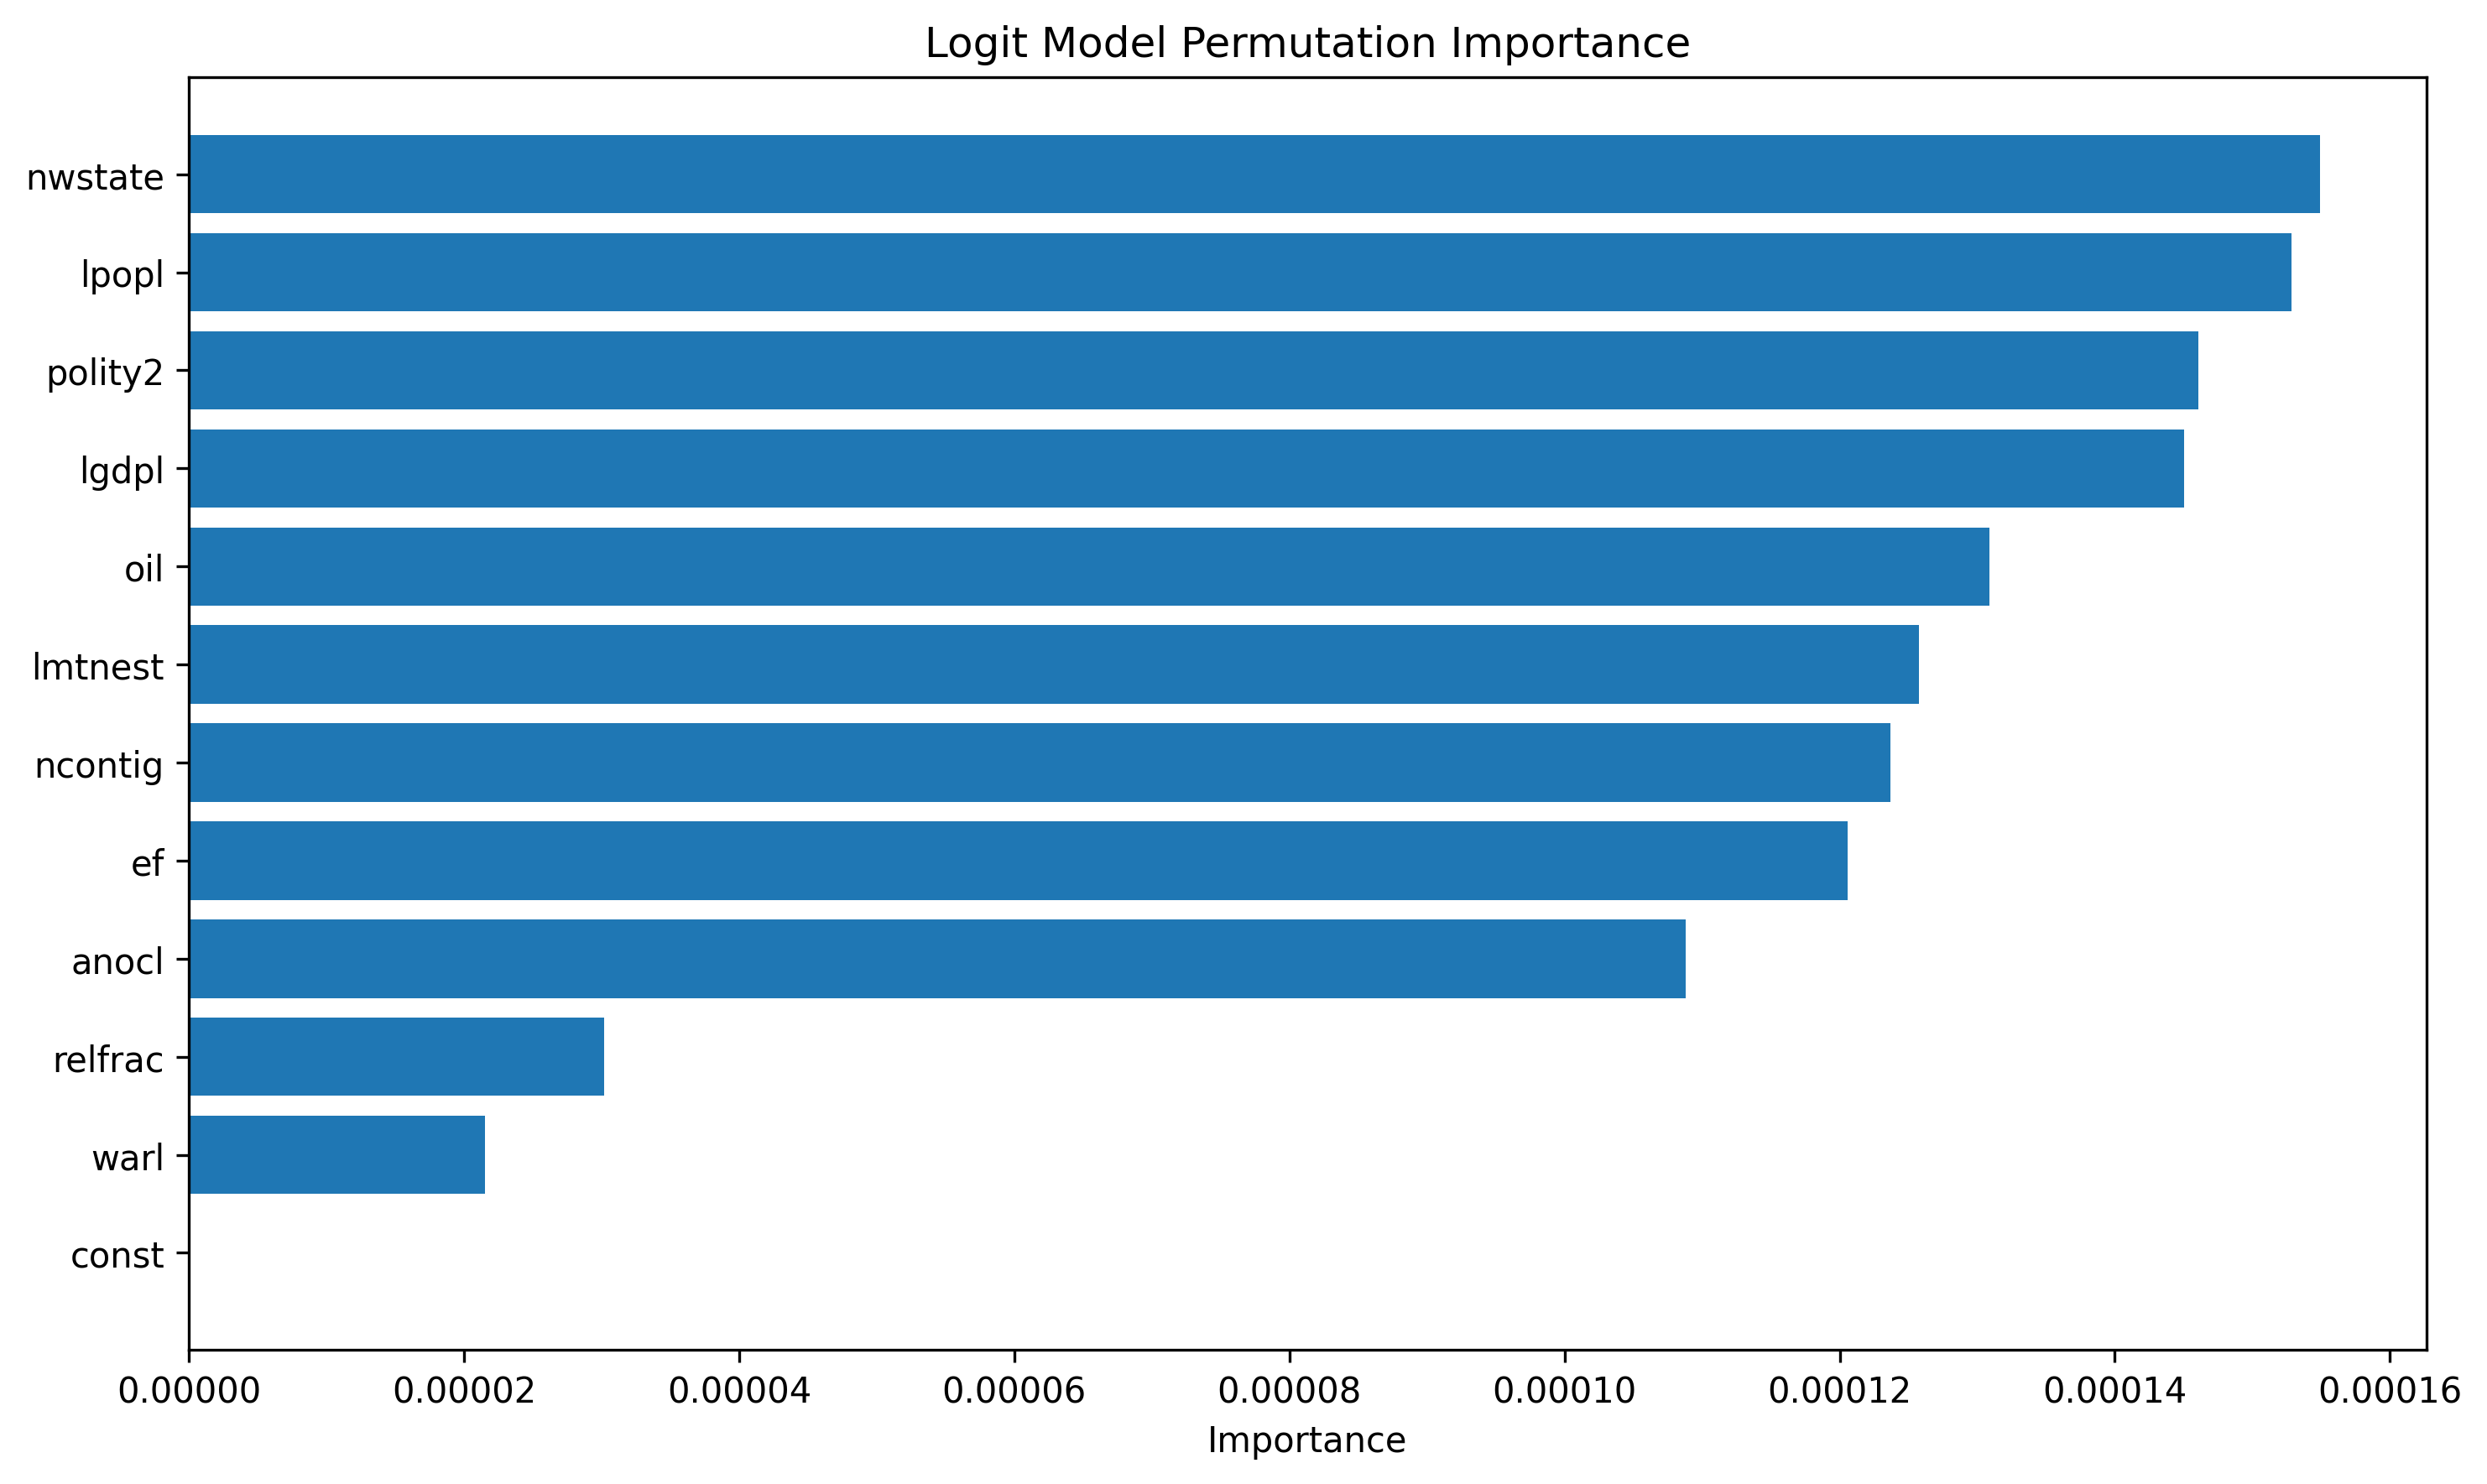

In [26]:
from sklearn.inspection import permutation_importance


# Calculate permutation importance
result = permutation_importance(fl_origmodel, X_train, y_train, n_repeats=1000, random_state=2025)

# Store and display results in a DataFrame
importance_df = pd.DataFrame({'Feature': X_test.columns, 
                              'Importance_mean': result.importances_mean, 
                              'Importance_std': result.importances_std})
importance_df = importance_df.sort_values(by='Importance_mean', ascending=False)

print(importance_df)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
# Optional: Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance_mean'])
plt.xlabel('Importance')
plt.title('Logit Model Permutation Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. SHAP Plots

In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

# STEP 1: Select your X and y
# Assuming df has 'country', 'year', and your features + target
fl_clean = fl_clean.dropna()
X = fl_clean [['warl', 'lgdpl', 'lpopl', 'lmtnest', 'ncontig', 'oil',
              'nwstate', 'anocl', 'ef', 'relfrac']]
y = fl_clean['onset']
# STEP 2: Apply SMOTE
smote = SMOTE(random_state=2025)
X_resampled, y_resampled = smote.fit_resample(X, y)

# STEP 3: Train a Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=2025)
rf.fit(X, y)

# STEP 4: Extract row for 'SY' in 2011
row = fl[(fl['country'] == 'Syria') & (fl['year'] == 2011)]
X_row = row[['warl', 'lgdpl', 'lpopl', 'lmtnest', 'ncontig', 'oil',
              'nwstate', 'anocl', 'ef', 'relfrac']]

prob = rf.predict_proba(X_row)[:, 1]  # For class 1 (conflict)
print("Prediction probability for Syria 2011:", prob)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prediction probability for Syria 2011: [0.65]


Establish benchmark

In [28]:

# Filter the historical data for Syria (1945-2010)
historical_data = fl[(fl['country'] == 'Syria') & (fl['year'] <= 2010)]

# Prepare X for prediction (same features as X_row)
X_historical = historical_data[['warl', 'lgdpl', 'lpopl', 'lmtnest', 'ncontig', 'oil',
                                 'nwstate', 'anocl', 'ef', 'relfrac']]

# Get predictions (probabilities) for historical data
historical_predictions = rf.predict_proba(X_historical)  # Returns probabilities for each class

# Calculate the mean prediction (for class 1, e.g., conflict=1)
historical_base_value = historical_predictions[:, 1].mean()  # Average for conflict=1
print("Historical base value (Syria average 1945-2010):", historical_base_value)


# STEP 5: Use SHAP to explain prediction
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_row)



Historical base value (Syria average 1945-2010): 0.01707692307692308


Calculate SHAP values for given (local) observation

In [29]:
# Extract SHAP values for class 1; if this was a continuous outcome wouldn't needed to specify in index
shap_class_1_values = shap_values.values[0, :, 1]

# Sum the SHAP values for class 1 (sum of each feature)
shap_class_1_sum = shap_class_1_values.sum()

# Base value for class 1 (taken from the TreeExplainer)
base_value_class_1 = shap_values.base_values[0, 1]  # Base value for class 1

# Calculate the final SHAP-based prediction for class 1
shap_prediction_class_1 = base_value_class_1 + shap_class_1_sum

# Compare with the model's prediction probability for class 1
model_prediction_class_1 = rf.predict_proba(X_row)[:, 1]

# Output both predictions
print(f"SHAP-based prediction (class 1) for Syria in 2011: {shap_prediction_class_1}")
print(f"Model prediction (predict_proba for class 1) for Syria in 2011: {model_prediction_class_1}")



SHAP-based prediction (class 1) for Syria in 2011: 0.6500000000000006
Model prediction (predict_proba for class 1) for Syria in 2011: [0.65]


Calculate SHAP object to plot

In [30]:
i = 0  # index of the row (for Syria in 2011)
class_idx = 1  # index for class (e.g., conflict = 1)

# Build a single-explanation object for waterfall plot
shap_single = shap.Explanation(
    values=shap_values.values[i, :, class_idx],  # SHAP values for class 1, for the i-th row (Syria 2011)
    base_values=historical_base_value,           # Manually set base value for Syria 1945-2010 average
    data=shap_values.data[i],                    # Feature values for the i-th row
    feature_names=shap_values.feature_names      # Feature names (e.g., ['warl', 'lgdpl', ...])
)

#check
print("Base value:", shap_single.base_values) #benchmark
#output follows additive property
print("Model output:", shap_single.base_values + shap_single.values.sum())
print("SHAP values:", shap_single.values)


Base value: 0.01707692307692308
Model output: 0.6525546000706803
SHAP values: [0.01708145 0.13857676 0.14119998 0.08485467 0.00670961 0.0736733
 0.00068097 0.01874541 0.07870725 0.07524828]


### i. waterfall plot

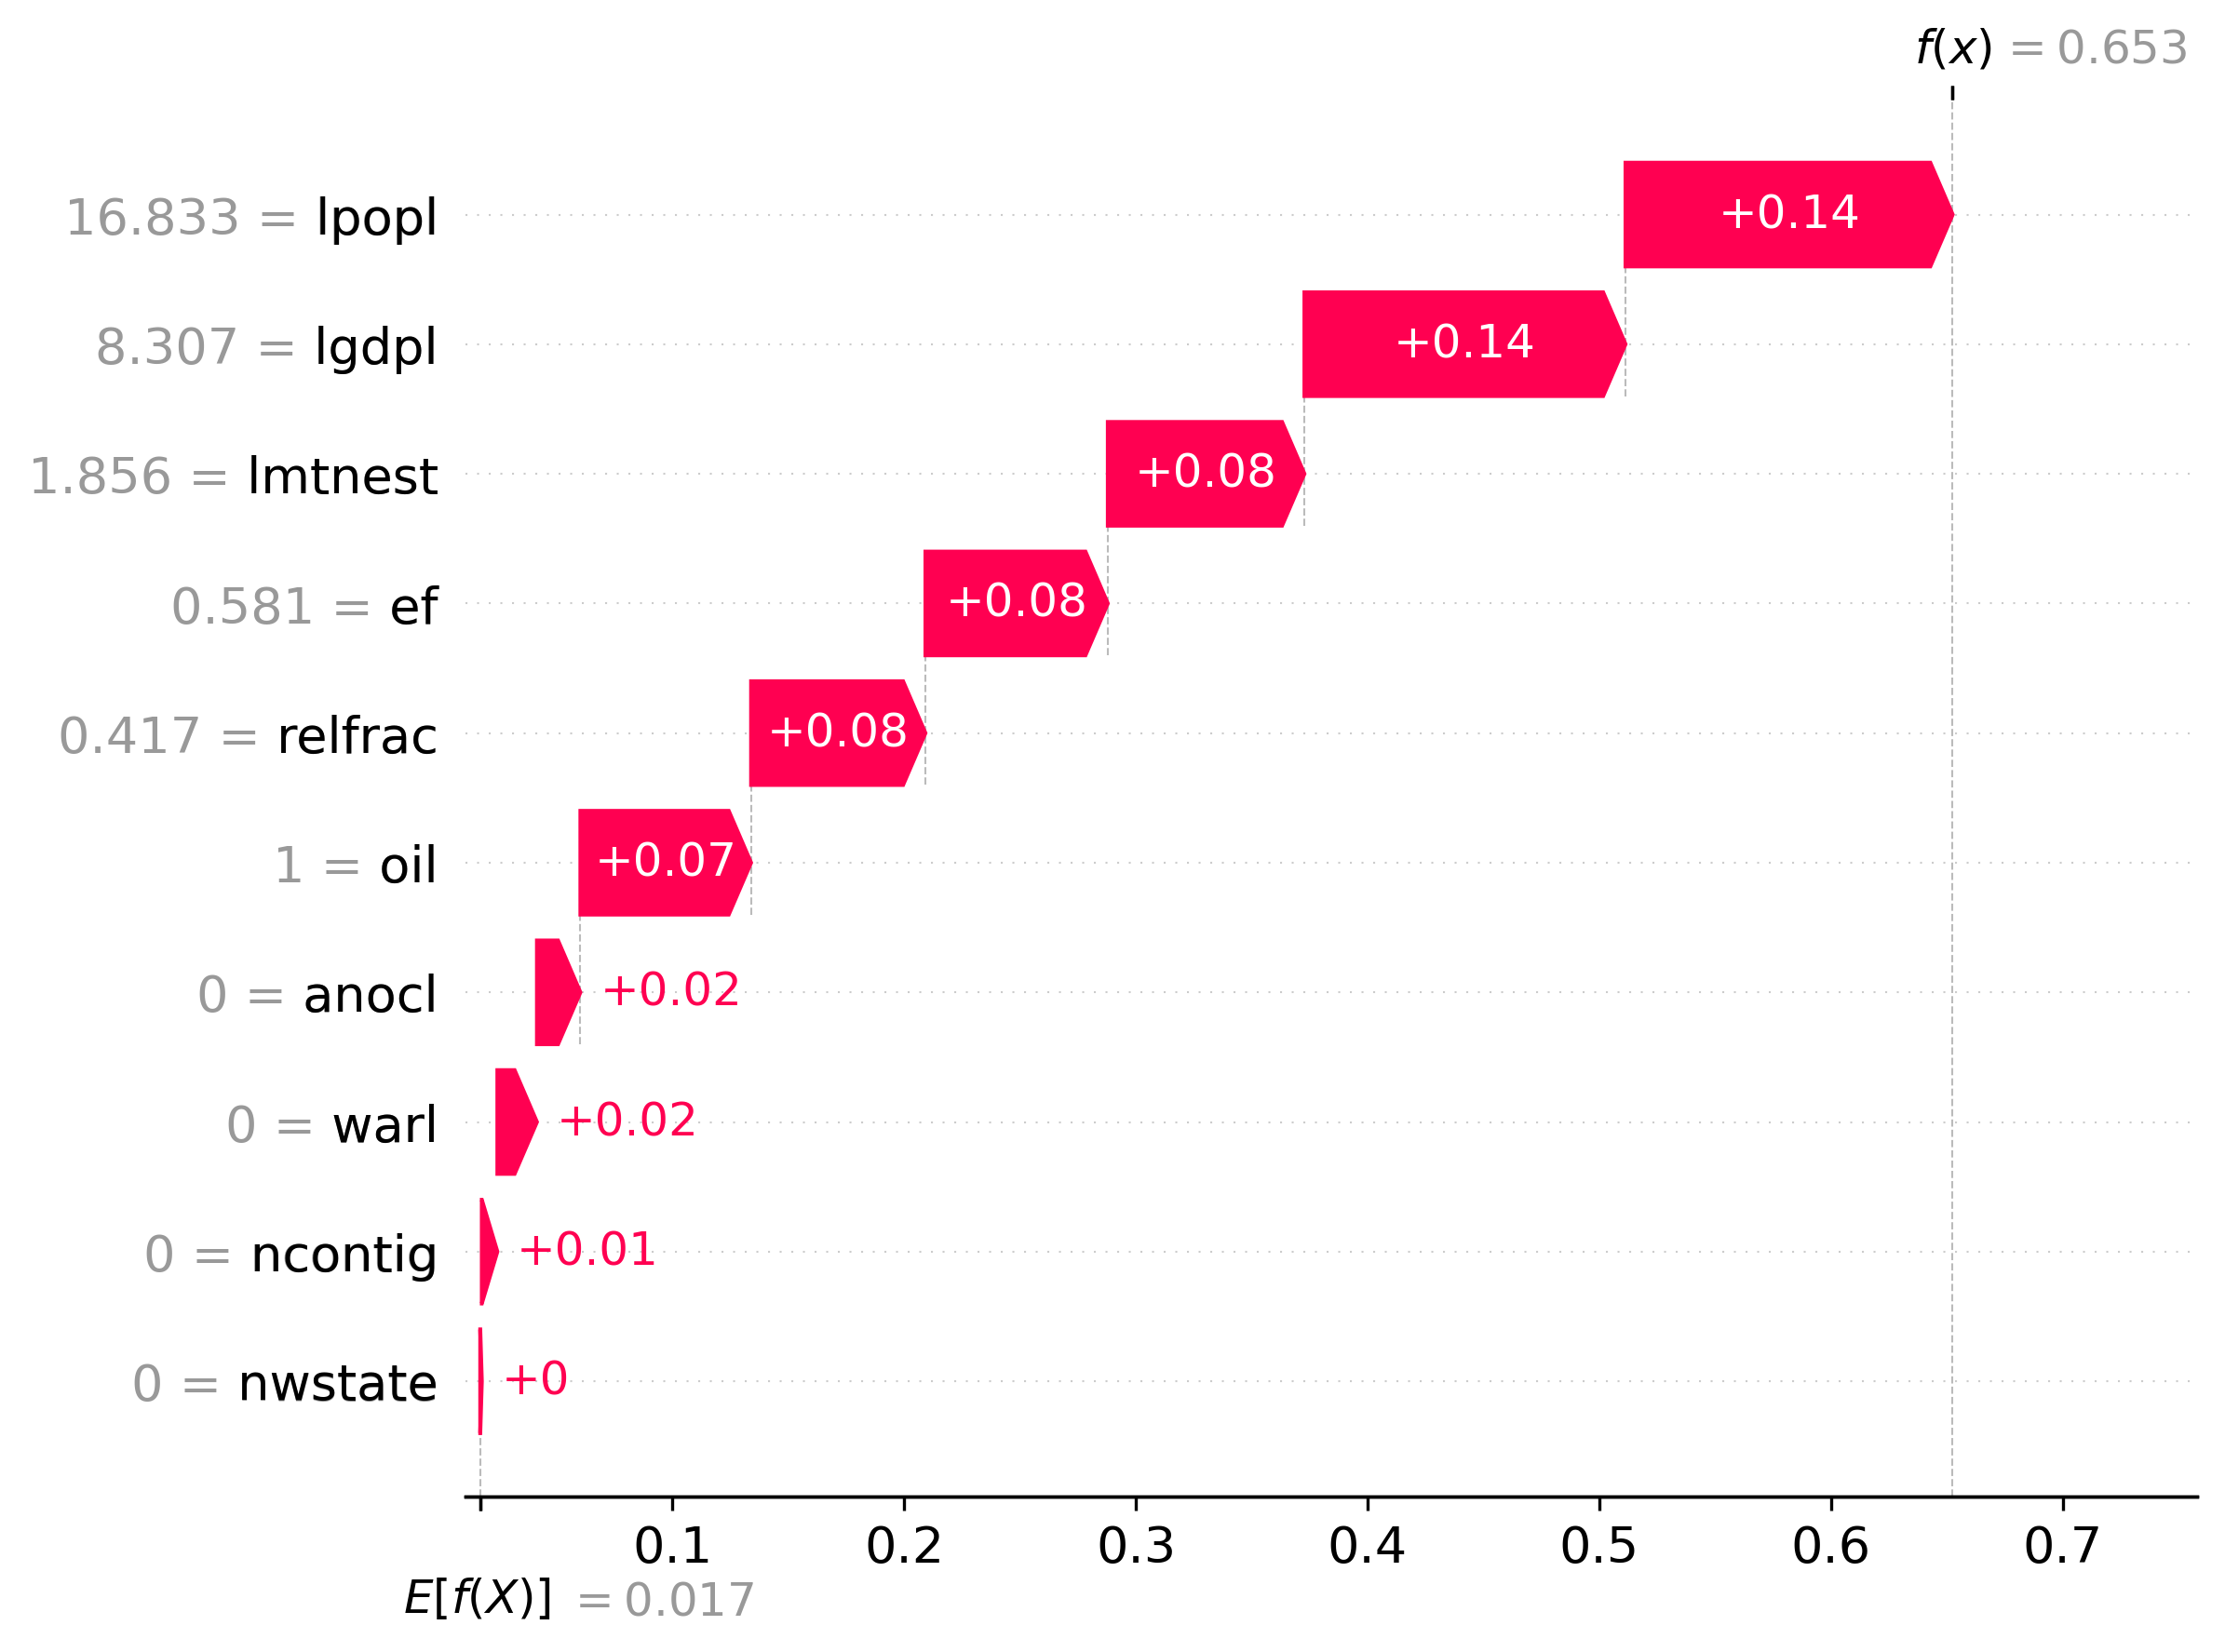

In [31]:

# Plot the waterfall plot (max_display to show top features)
shap.plots.waterfall(shap_single, max_display=10)

### ii. force plot

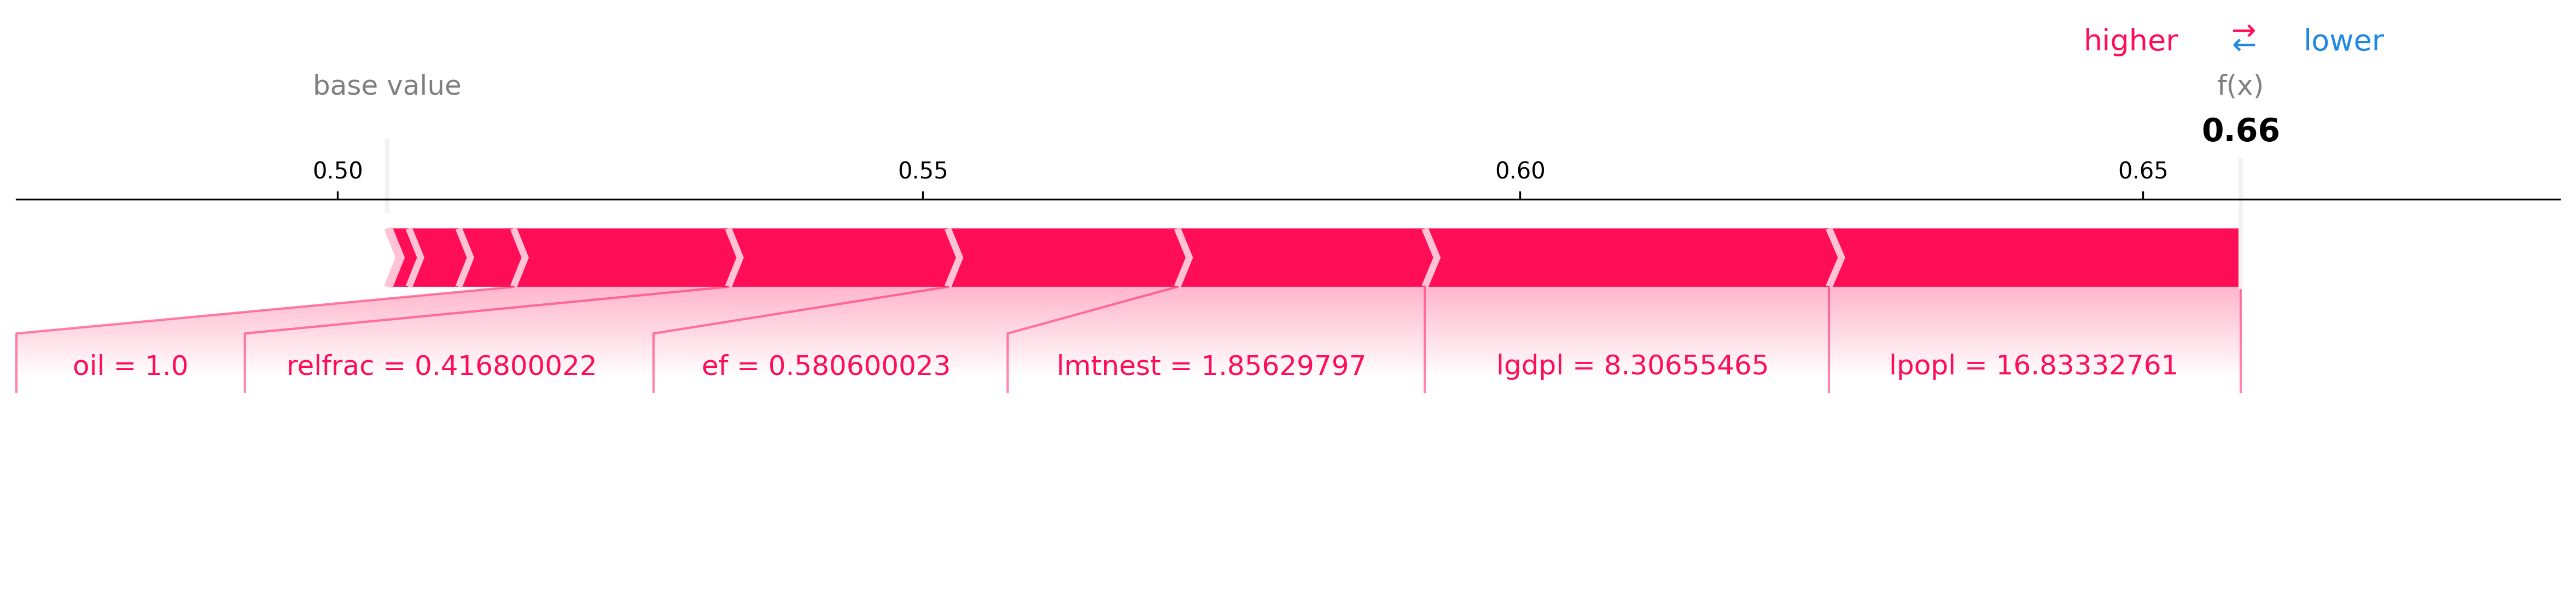

In [32]:
shap.plots.force(shap_single,
    link="logit",
    matplotlib=True)

Examine another country for comparison

Prediction probability for US 2011: [0.]
Historical base value (US 1989): 0.0


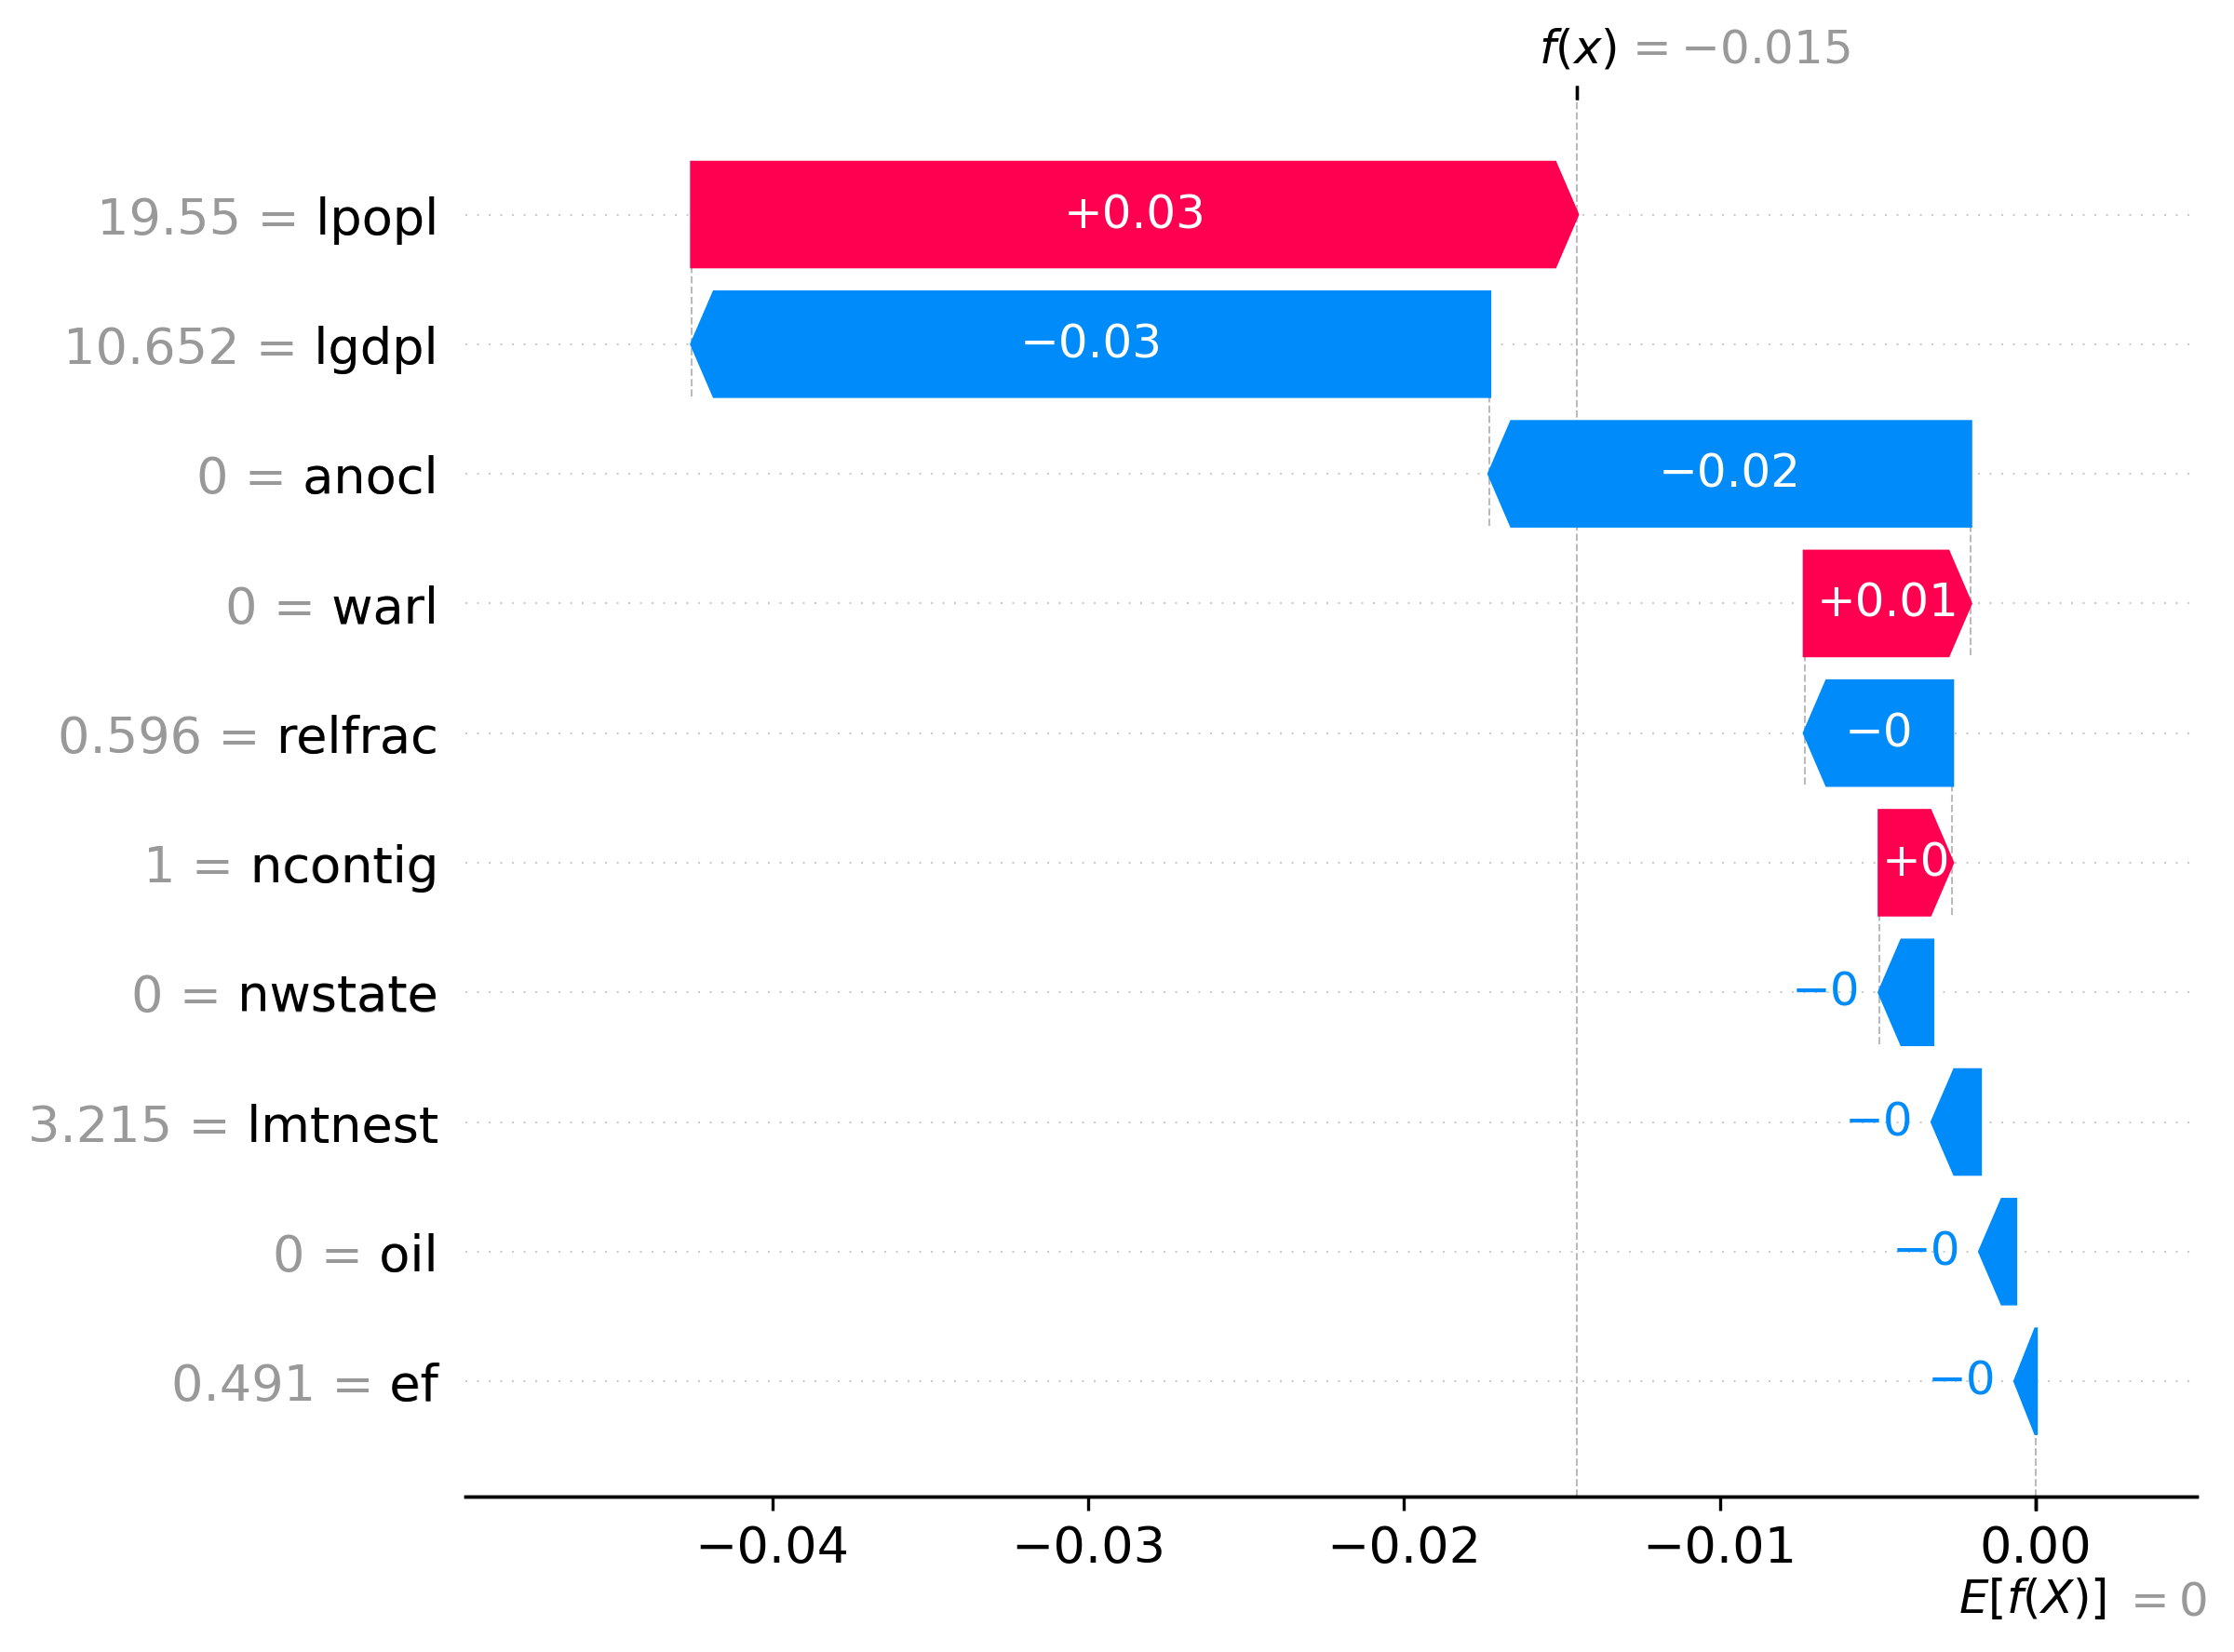

In [33]:

#Examine civil war risk for US
row = fl[(fl['country'] == 'United States of America') & (fl['year'] == 2011)]
X_row = row[['warl', 'lgdpl', 'lpopl', 'lmtnest', 'ncontig', 'oil',
              'nwstate', 'anocl', 'ef', 'relfrac']]

prob = rf.predict_proba(X_row)[:, 1]  # For class 1 (conflict)
print("Prediction probability for US 2011:", prob)

## Create benchmark value
# Filter the historical data for US and specific year, e.g. 1989
historical_data = fl[(fl['country'] == 'United States of America') & (fl['year']== 1989)]

# Prepare X for prediction (same features as X_row)
X_historical = historical_data[['warl', 'lgdpl', 'lpopl', 'lmtnest', 'ncontig', 'oil',
                                 'nwstate', 'anocl', 'ef', 'relfrac']]

# Get predictions (probabilities) for historical data
historical_predictions = rf.predict_proba(X_historical)  # Returns probabilities for each class

# Calculate the mean prediction (for class 1, e.g., conflict=1)
historical_base_value = historical_predictions[:, 1].mean()  # Average for conflict=1
print("Historical base value (US 1989):", historical_base_value)


explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_row)

# Extract SHAP values for class 1 (second column)
shap_class_1_values = shap_values.values[0, :, 1]

# Sum the SHAP values for class 1 (sum over features)
shap_class_1_sum = shap_class_1_values.sum()

# Base value for class 1 (taken from the TreeExplainer)
base_value_class_1 = shap_values.base_values[0, 1]  # Base value for class 1

# Calculate the final SHAP-based prediction for class 1
shap_prediction_class_1 = base_value_class_1 + shap_class_1_sum

# Compare with the model's prediction probability for class 1
model_prediction_class_1 = rf.predict_proba(X_row)[:, 1]

# Extract SHAP values for the first observation and class index 1 (e.g., "conflict = 1")
i = 0  # index of the row (for Syria in 2011)
class_idx = 1  # index for class (e.g., conflict = 1)

# Build a single-explanation object for waterfall plot
shap_single = shap.Explanation(
    values=shap_values.values[i, :, class_idx],  # SHAP values for class 1, for the i-th row (Syria 2011)
    base_values=historical_base_value,           # Manually set base value for Syria 1945-2010 average
    data=shap_values.data[i],                    # Feature values for the i-th row
    feature_names=shap_values.feature_names      # Feature names (e.g., ['warl', 'lgdpl', ...])
)

# Plot the waterfall plot (max_display to show top features)
shap.plots.waterfall(shap_single, max_display=10)



*Commentary* Note that SHAP can return negative values!

## 5. PDP

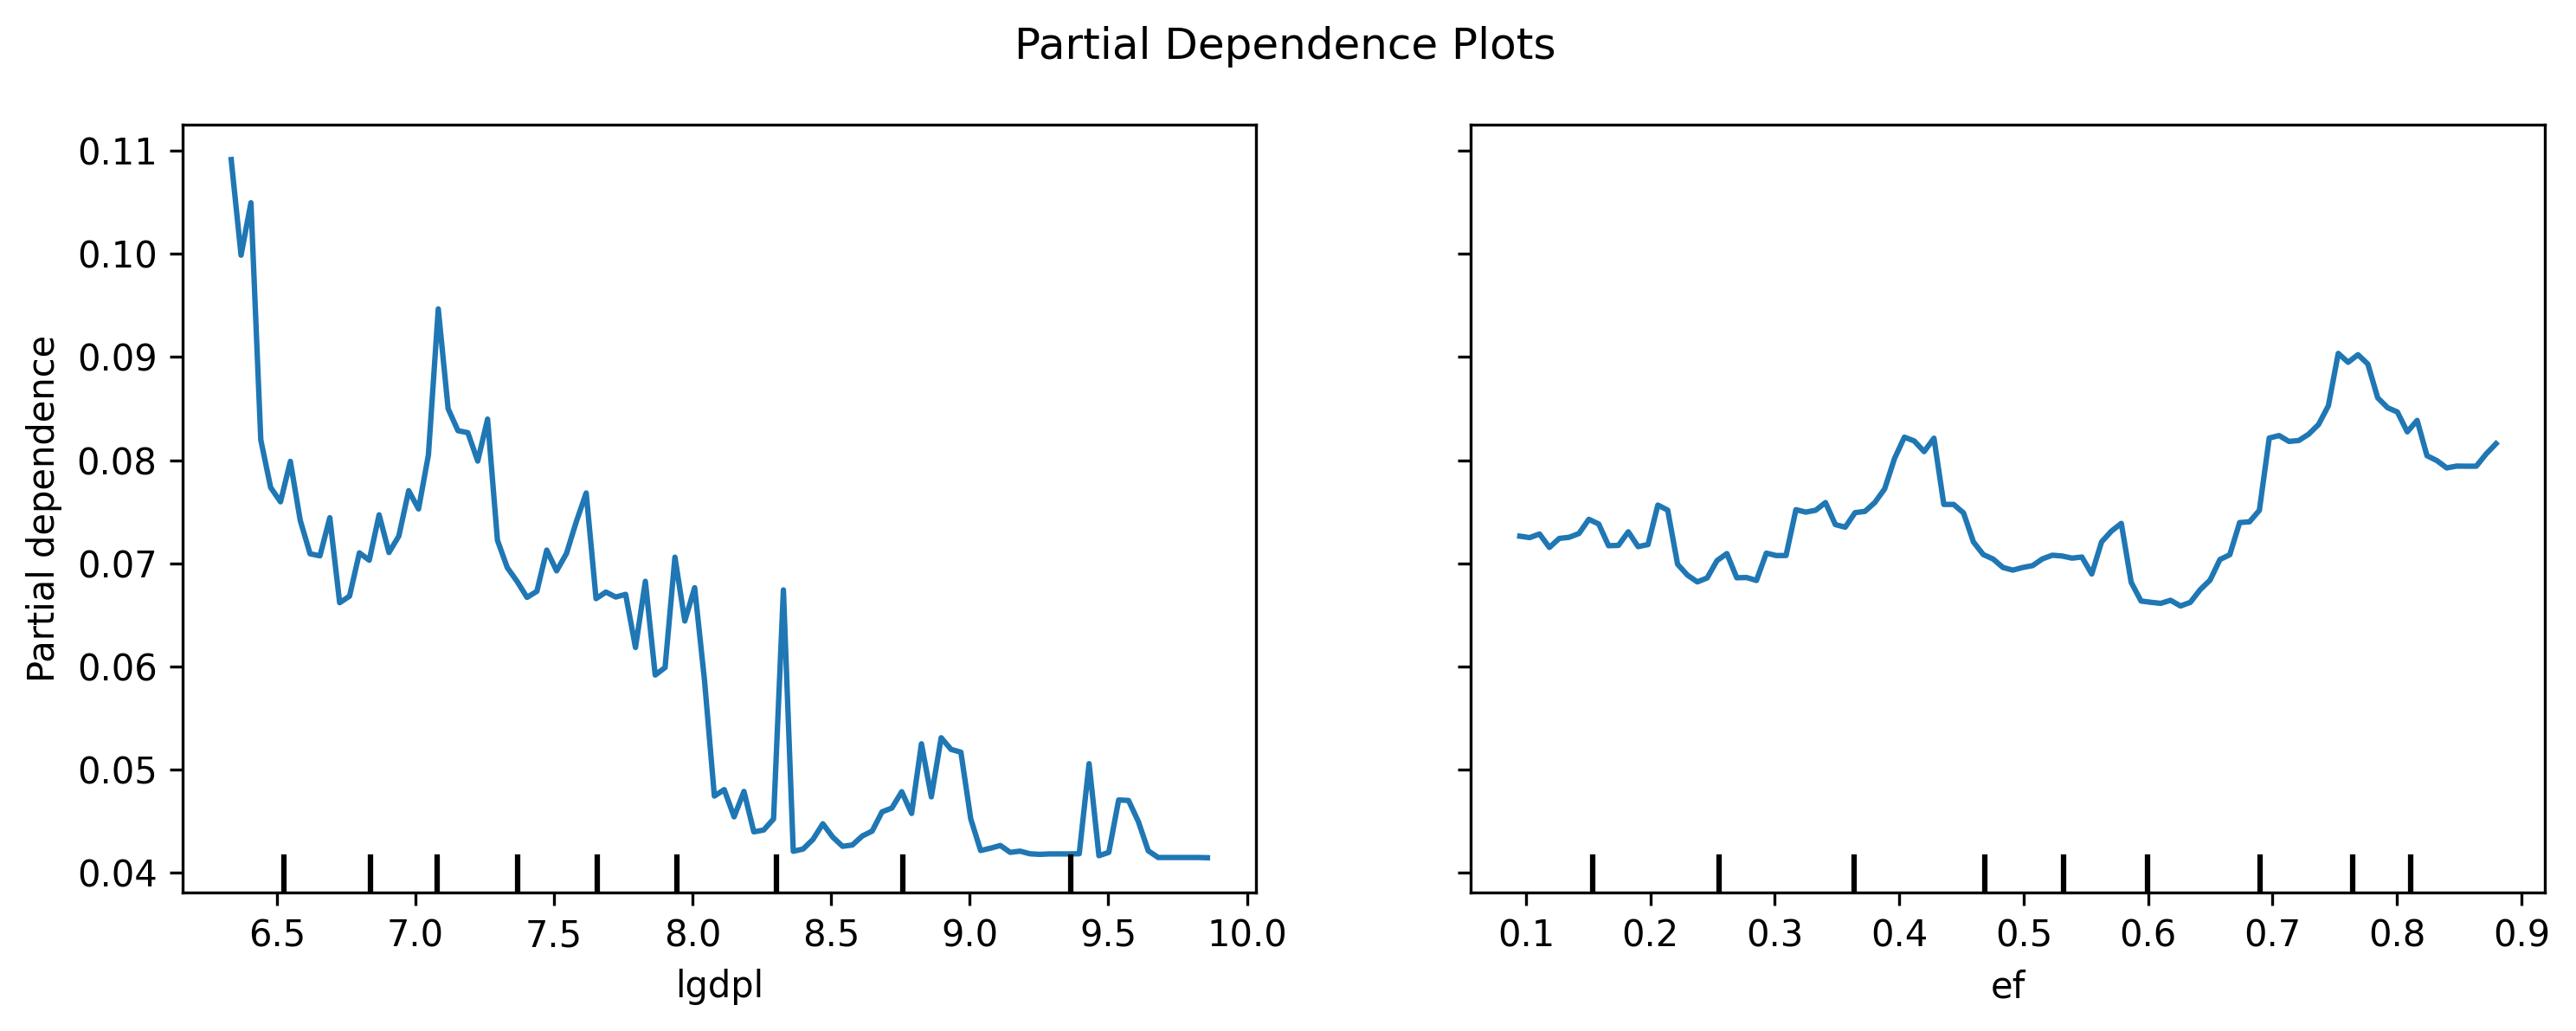

In [34]:

from sklearn.inspection import PartialDependenceDisplay



# Pick features to examine PDP
features = ['lgdpl', 'ef']

fig, ax = plt.subplots(figsize=(10, 4))
PartialDependenceDisplay.from_estimator(rf, X_resampled, features, ax=ax)
plt.suptitle("Partial Dependence Plots")
plt.tight_layout()
plt.show()


## 6. Simulations and Stress-Testing

We need to create two function to implement Tomz, King, and Wittenberg suggestion:
1. New X matrix: This is a new dataframe that is a matrix of all predictor variables we want to reestimate. We generally only want to change one xvar at a time to isolate the effect of that variable. However we could modify this function to modify 2 or more.
2. Simulation wrapper: this will sample from the variance-covariance matrix and then apply the link function to those new values to get our range of predicted outputs

In [35]:
def x_mat(model, X, xvar, xvar_value):
    """
    Create a matrix of predictor values with all variables set to their mean,
    except `xvar`, which is set to `xvar_value`.

    Parameters:
    - model: trained LogisticRegression model
    - X: original DataFrame of features used to fit the model
    - xvar: str, name of the feature to modify
    - xvar_value: value to assign to the specified feature

    Returns:
    - x_mat: 2D numpy array suitable for model.predict() or model.predict_proba()
    """
    # Start with mean of all features
    row = X.mean(skipna=True)

    # Replace xvar with the specific value
    if xvar in row.index:
        row[xvar] = xvar_value
    else:
        raise ValueError(f"{xvar} not found in X columns.")

    # Reshape to 2D matrix
    x_mat = row.values.reshape(1, -1)

    return x_mat

Simulation wrapper - this is currently just set up to examine OLS and logit, but you could also add probit, tobit, lasso, ridge, etc.

In [36]:
import numpy as np
from scipy.stats import multivariate_normal

def sim_wrapper(model_type, model, num_sims, x):
    num_coefficients = len(model.params)  # Number of coefficients in the model
    num_features = x.shape[1]  # Number of features in the input data
    
    if model_type == "logit":
        gamma = model.params.values  # Coefficients (including intercept)
        sigma = model.cov_params().values  # Covariance matrix of coefficients
        
        # Simulate coefficients from multivariate normal distribution
        gamma_hat = np.array([multivariate_normal.rvs(mean=gamma, cov=sigma) for _ in range(num_sims)])

        # Separate alpha (intercept) and beta (coefficients for features)
        alpha_hat = gamma_hat[:, 0]  # Intercept terms
        beta_hat = gamma_hat[:, 1:]  # Coefficients for features
        
        if num_coefficients == num_features + 1: 
           
            x_with_intercept = np.hstack([np.ones((x.shape[0], 1)), x])  
        elif num_coefficients == num_features:  
            x_with_intercept = x  
        else:
            raise ValueError(f"Model coefficients ({num_coefficients}) and features ({num_features}) mismatch.")
        
        beta_hat = np.hstack([np.zeros((beta_hat.shape[0], 1)), beta_hat])  # Add zero intercept column

       
        # Calculate the simulated predicted probabilities using the logistic link function
        sim_out_yhat = np.exp(alpha_hat[:, None] + (beta_hat @ x_with_intercept.T)) / (1 + np.exp(alpha_hat[:, None] + (beta_hat @ x_with_intercept.T)))

        return sim_out_yhat

    elif model_type == "ols":
        gamma = model.params.values
        sigma = model.cov_params().values
        # Simulate coefficients from multivariate normal distribution
        gamma_hat = np.array([multivariate_normal.rvs(mean=gamma, cov=sigma) for _ in range(num_sims)])

        alpha_hat = gamma_hat[:, 0]
        beta_hat = gamma_hat[:, 1:]

        # Check if the model includes an intercept
        if num_coefficients == num_features + 1:  
        # Add intercept term to x
            x_with_intercept = np.hstack([np.ones((x.shape[0], 1)), x])  
        elif num_coefficients == num_features:  
            x_with_intercept = x  
        else:
            raise ValueError(f"Model coefficients ({num_coefficients}) and features ({num_features}) mismatch.")
        
        beta_hat = np.hstack([np.zeros((beta_hat.shape[0], 1)), beta_hat])  # Add zero intercept column

                # Simulate outcome using OLS
        sim_out = beta_hat @ x_with_intercept.T + alpha_hat[:, None]

        return sim_out

    else:
        raise ValueError('Model type must be "logit" or "ols".')


### i. Example: Economic Shocks and Civil War Onset

Choose our parameters

In [37]:
#for base case, take model_train and X_train matrix, hold lgdpl fixed at 5 and take mean of all other variables

basecase = x_mat(model_train, X_train, 'lgdpl', 5)
downcase = x_mat(model_train, X_train, 'lgdpl', 2)
upcase = x_mat(model_train, X_train, 'lgdpl', 9)

Apply simulation wrapper

In [38]:


#apply this new base case to simulation wrapper to get new output series
sim_out_base = sim_wrapper("logit", model_stats, num_sims=1000, x=basecase)
sim_out_down = sim_wrapper("logit", model_stats, num_sims=1000, x=downcase)
sim_out_up = sim_wrapper("logit", model_stats, num_sims=1000, x=upcase)

Visualize results

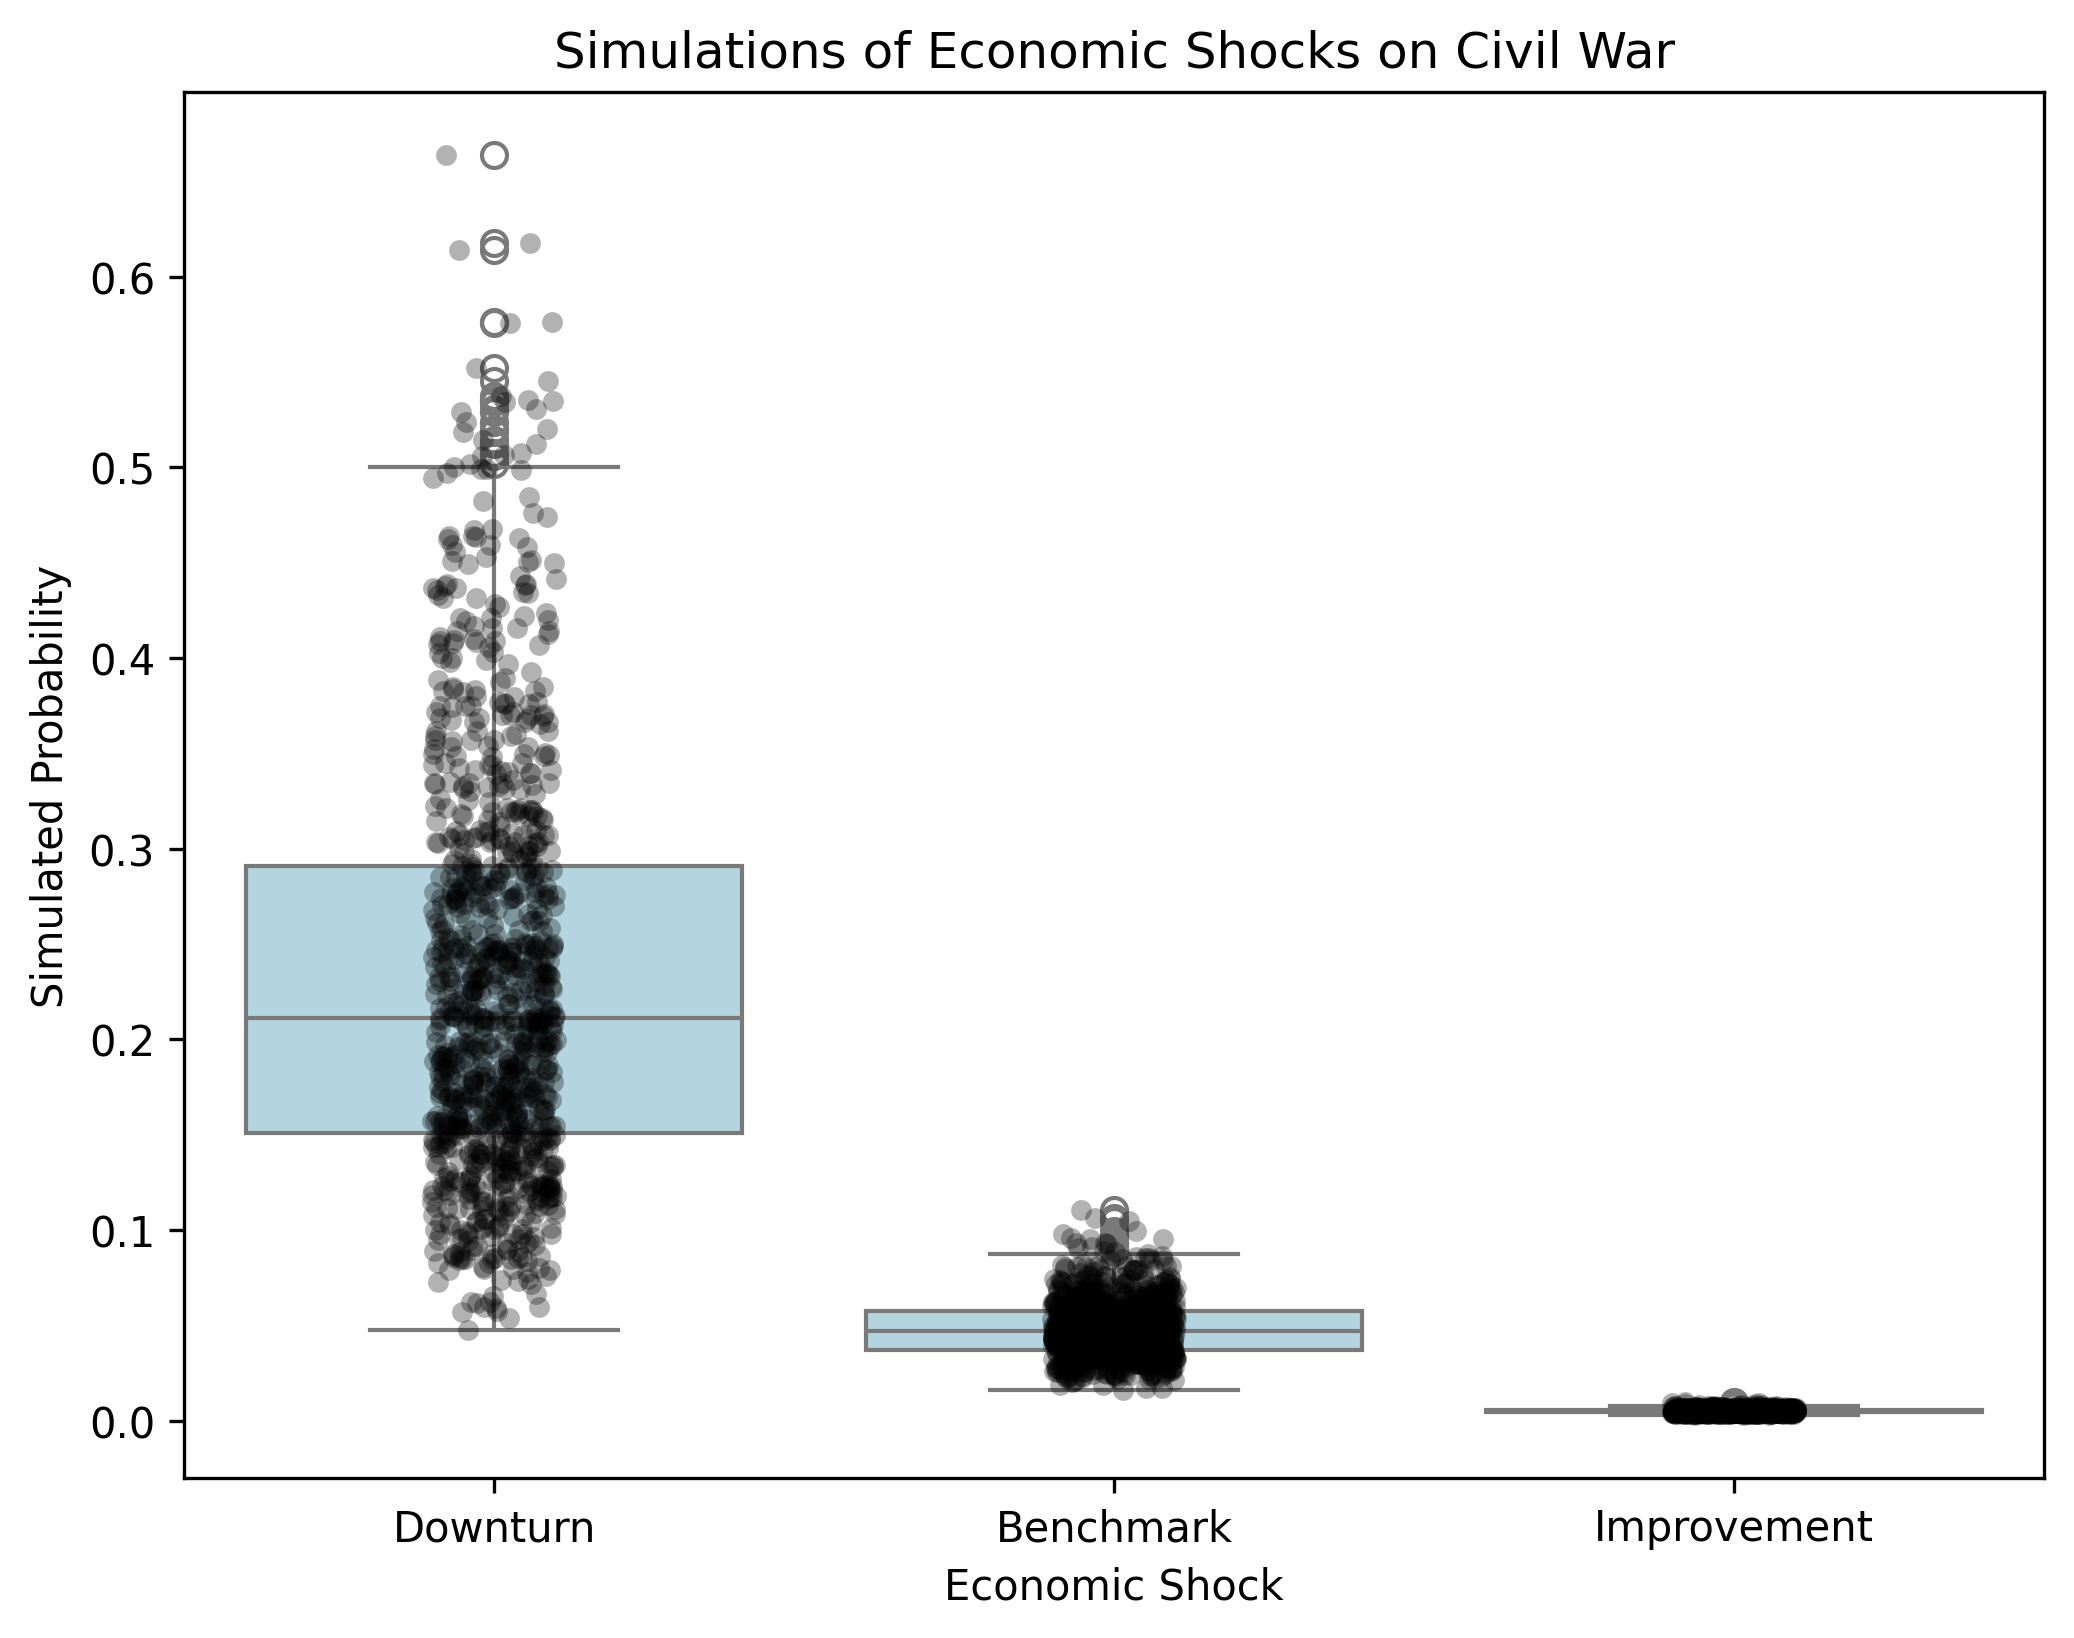

In [39]:

#Convert the results to df for plotting and additional analysis
df = pd.DataFrame({
    'Simulated Probability': np.concatenate([ sim_out_down.flatten(), sim_out_base.flatten(), sim_out_up.flatten()]),
    'Scenario': ['Downturn'] * sim_out_down.size + ['Benchmark'] * sim_out_base.size  + ['Improvement'] * sim_out_up.size
})

# Create the plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Scenario', y='Simulated Probability', data=df, color='lightblue')
sns.stripplot(x='Scenario', y='Simulated Probability', data=df, jitter=True, color='black', alpha=0.3)

# Add titles and labels
plt.title('Simulations of Economic Shocks on Civil War')
plt.xlabel('Economic Shock')
plt.ylabel('Simulated Probability')

# Show the plot
plt.show()


### ii. Example: Regime Shocks

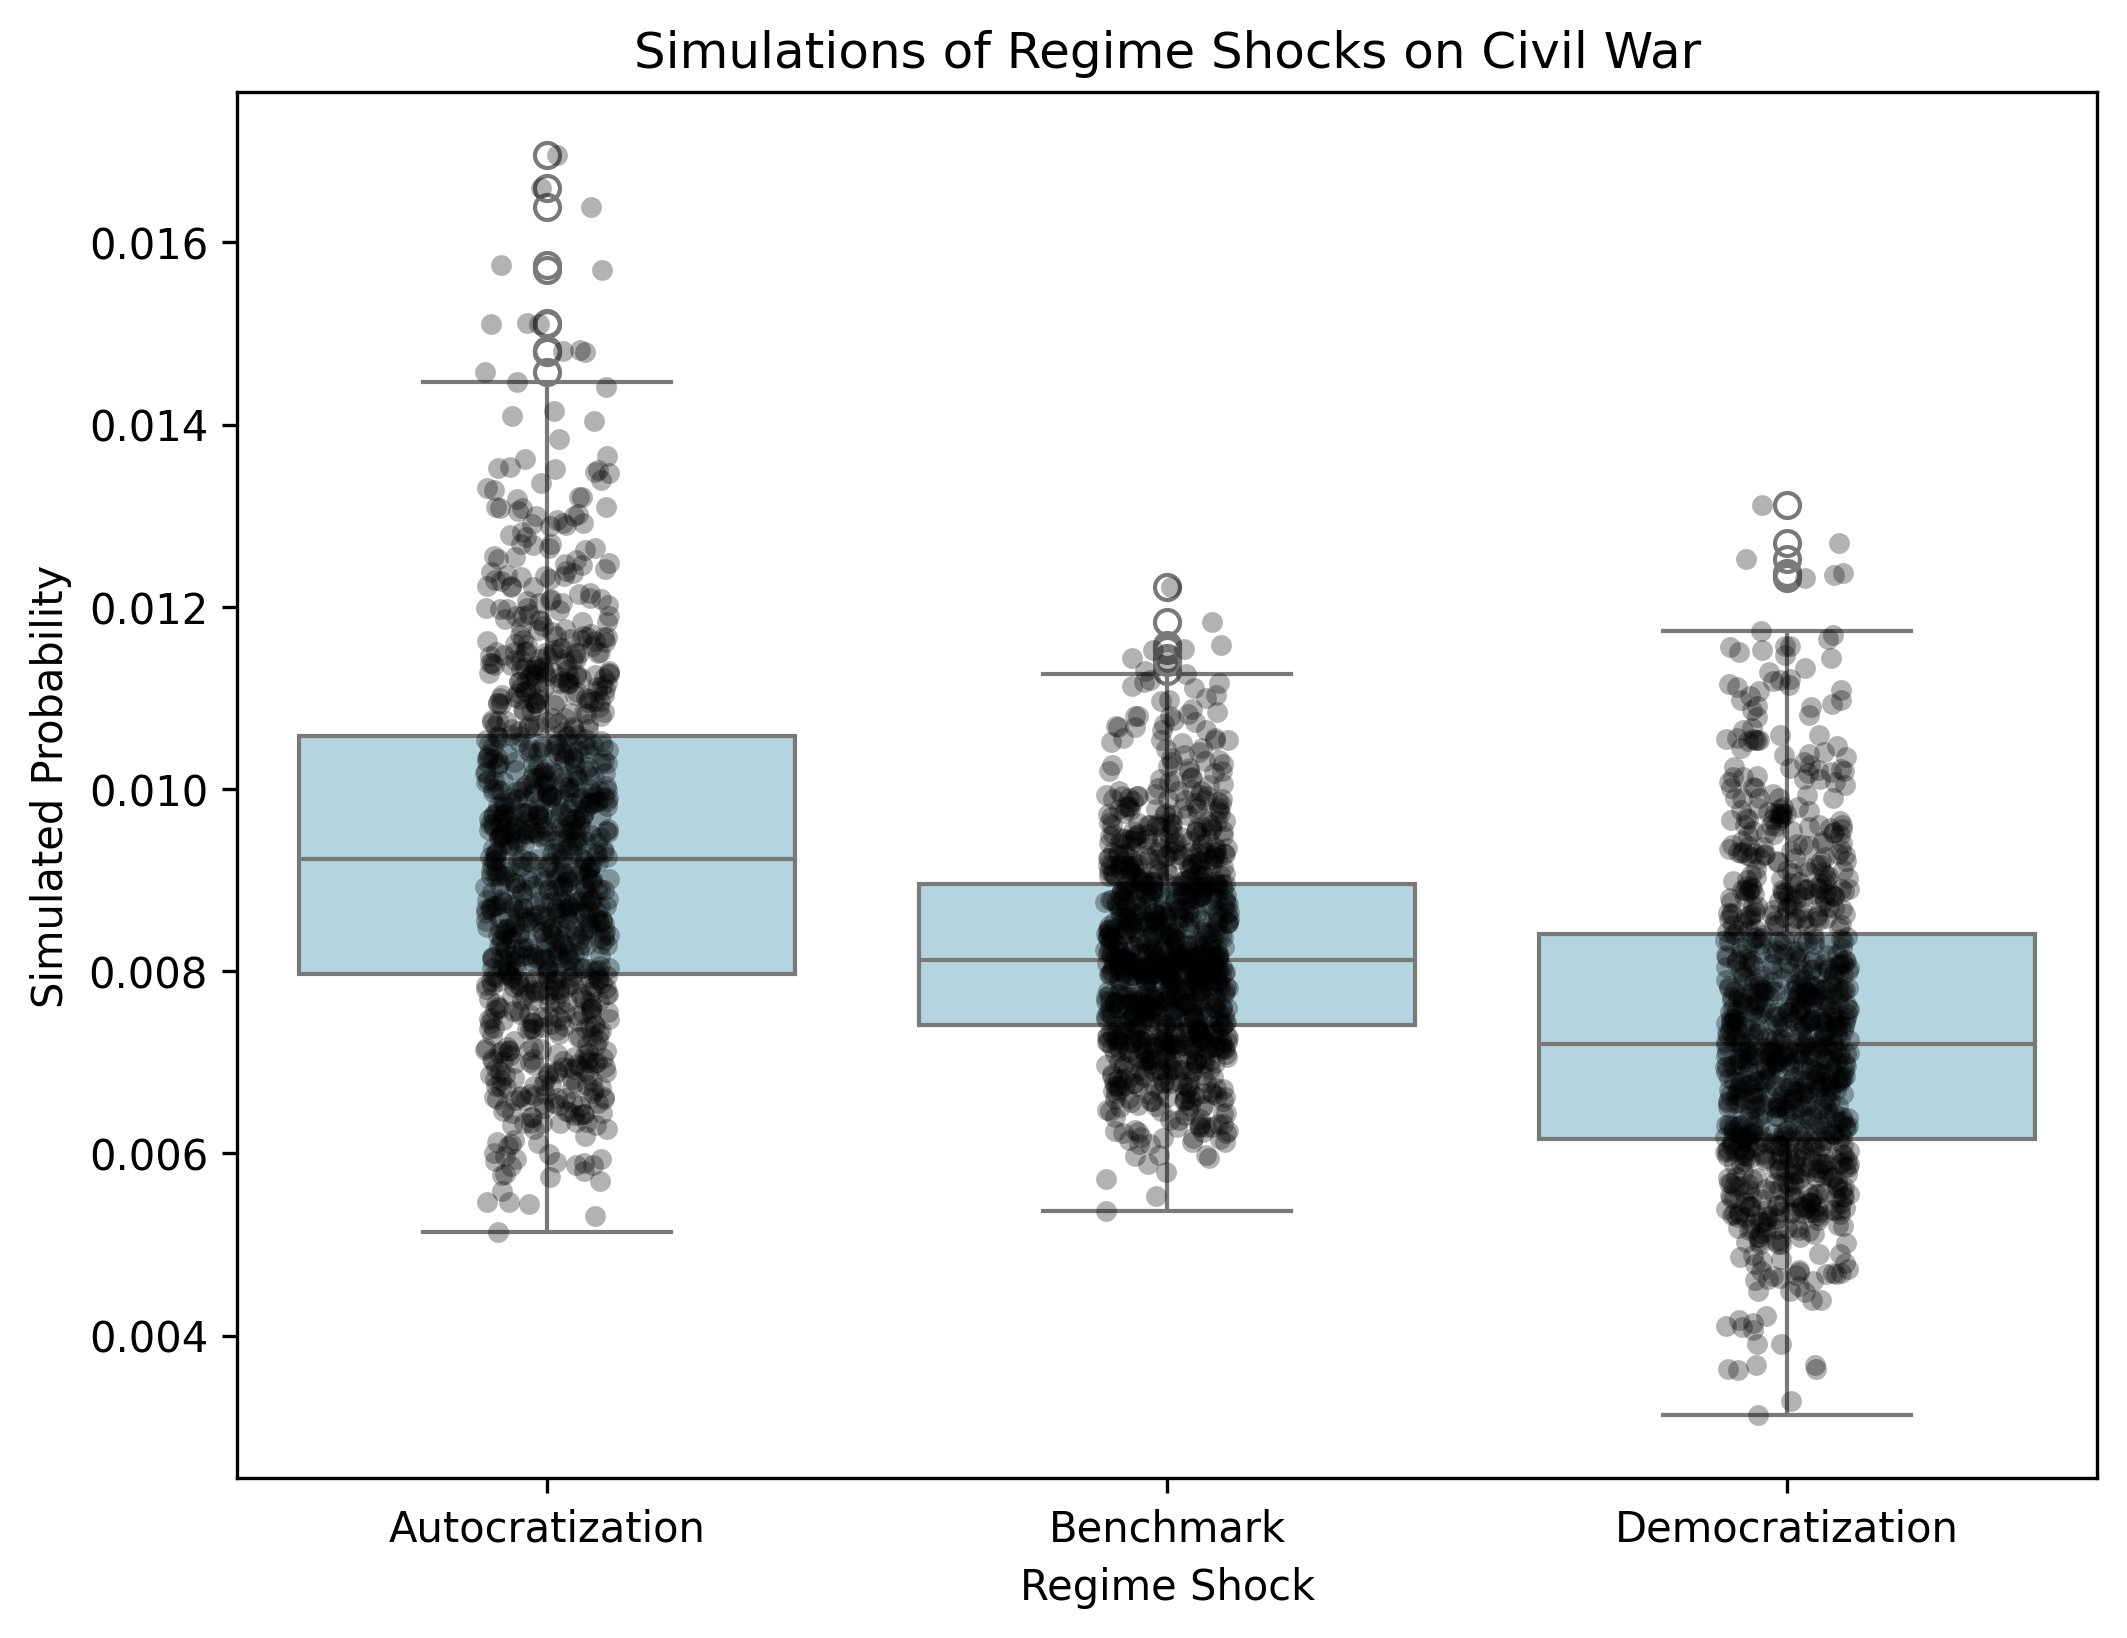

In [40]:
#Same as above - look at reigme shocks varying levels at [-10, 0, 10]
basecase = x_mat(model_train, X_train, 'polity2', 0) #take average or impute 
downcase = x_mat(model_train, X_train, 'polity2', -10)
upcase = x_mat(model_train, X_train, 'polity2', 10)

# Assuming sim_out_base and sim_out_down are your simulated outcomes from the wrapper function
sim_out_base = sim_wrapper("logit", model_stats, num_sims=1000, x=basecase)
sim_out_down = sim_wrapper("logit", model_stats, num_sims=1000, x=downcase)
sim_out_up = sim_wrapper("logit", model_stats, num_sims=1000, x=upcase)
# Convert the results to a DataFrame for easier plotting
df = pd.DataFrame({
    'Simulated Probability': np.concatenate([ sim_out_down.flatten(), sim_out_base.flatten(), sim_out_up.flatten()]),
    'Scenario': ['Autocratization'] * sim_out_down.size + ['Benchmark'] * sim_out_base.size  + ['Democratization'] * sim_out_up.size
})

# Create the plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Scenario', y='Simulated Probability', data=df, color='lightblue')
sns.stripplot(x='Scenario', y='Simulated Probability', data=df, jitter=True, color='black', alpha=0.3)

# Add titles and labels
plt.title('Simulations of Regime Shocks on Civil War')
plt.xlabel('Regime Shock')
plt.ylabel('Simulated Probability')

# Show the plot
plt.show()
